## Problema de Negócio

O conjunto de dados está disponível na plataforma do Kaggle, através desse link: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction 

Cada linha representa um cliente e cada coluna contém alguns atributos que descrevem esse cliente, além da sua resposta à pesquisa, na qual ela mencionou interesse ou não ao novo produto de seguros. 

O conjunto de dados inclui as seguintes informações:

Id: identificador único do cliente.

Gender: gênero do cliente.

Age: idade do cliente.

Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )

Region Code: código da região do cliente.

Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.

Vehicle Age: idade do veículo.

Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.

Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.

Policy sales channel: código anônimo para o canal de contato com o cliente.

Vintage: número de dias que o cliente se associou à empresa através da compra do seguro de saúde.

Response: 0, o cliente não tem interesse e 1, o cliente tem interesse.

# 0.0 Imports 

In [118]:
import os
import inflection
import pickle
import pandas                as pd
import numpy                 as np
import psycopg2              as pg
import seaborn               as sns
import pandas.io.sql         as psql
import scikitplot            as skplt
import matplotlib.pyplot     as plt
import plotly.offline        as py
import plotly.graph_objs     as go
import plotly.figure_factory as ff


from IPython.display         import Image
from matplotlib              import gridspec
from IPython.core.display    import display, HTML
from scipy                   import stats
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from sklearn                 import preprocessing   as pp
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from sklearn                 import linear_model    as lm
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split


C:\Users\PC\AppData\Local\Temp\ipykernel_11992\4153112851.py:17: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



## 0.01 Helper Function

In [172]:
def numerical_statistics( dataframe ):
    '''Calculate statistics for all columns in the dataframe
    
    Args: 
        dataframe: dataframe with only numerical features
    
    Return: 
        stats_df: dataframe with statistics for every feature. 
                  Rows are original dataframe features.
                  Columns are statistics applied.'''
    
    # central tendency statistics
    mean_stats = pd.DataFrame( dataframe.apply( np.mean ) ).T
    median_stats  = pd.DataFrame( dataframe.apply( np.median ) ).T
    
    # deviation statistics
    std_stats = pd.DataFrame( dataframe.apply( np.std ) ).T
    min_stats = pd.DataFrame( dataframe.apply( min ) ).T
    max_stats = pd.DataFrame( dataframe.apply( max ) ).T
    range_stats = pd.DataFrame( dataframe.apply( lambda x: x.max() - x.min() ) ).T
    skew_stats = pd.DataFrame( dataframe.apply( lambda x: x.skew() ) ).T
    kurtosis_stats = pd.DataFrame( dataframe.apply( lambda x: x.kurtosis() ) ).T
    
    # concatenate statistics    
    stats_df = pd.concat( [  mean_stats,
                             median_stats,
                             std_stats,
                             min_stats,
                             max_stats,
                             range_stats,
                             skew_stats,
                             kurtosis_stats   ] ).T.reset_index()
    
    # rename columns
    stats_df.columns = ['attribute', 
                       'mean',
                       'median',
                       'std',
                       'min',
                       'max',
                       'range',
                       'skew',
                       'kurtosis'    ]
    
    
    return stats_df

def cramer_v_corrected_stat( series_one, series_two ):
    '''Calculate crame v statistics for two categorical series
        
    Args:
        series_one: first categorical dataframe column
        series_two: second categorical dataframe column
    
    Return:
        corr_cramer_v: corrected Cramer-V statistic
    '''
        
    # create confusion matrix
    cm = pd.crosstab( series_one, series_two )
    # calculate the sum along all dimensions
    n = cm.sum().sum()
    # calculate number of row and columns of confusion matrix
    r, k = cm.shape

    # calculate chi_squared statistics
    chi2 = stats.chi2_contingency( cm )[0]
    
    # calculate chi_squared correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    # calculate k correction
    kcorr = k - (k-1)**2/(n-1)
    # calculate r correction
    rcorr = r - (r-1)**2/(n-1)

    # calculate corrected cramer-v
    corr_cramer_v = np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
   
    
    return corr_cramer_v


def create_cramer_v_dataframe( categ_features_analysis_dataframe ):
    '''Create a correlation matrix for features on categorical dataframe
    
    Args:
        categ_features_analysis_dataframe: dataframe with only categorical features
    
    Return:
        categ_corr_matrix: dataframe with cramer-v for every row-column pair 
                           in the input dataframe'''
    
    # create final dataframe skeleton
    df_cramer_v = pd.DataFrame( columns = categ_features_analysis_dataframe.columns, 
                                index = categ_features_analysis_dataframe.columns )

    # fill final dataframe with cramer-v statistics for every row-column pair
    for row in df_cramer_v:
        for column in df_cramer_v:   
            df_cramer_v.loc[row, column] = float( cramer_v_corrected_stat( categ_features_analysis_dataframe[ row ],
                                                                           categ_features_analysis_dataframe[ column] ) )

    # ensure cramer-v is float
    categ_corr_matrix = df_cramer_v.astype( 'float' )
        
        
    return categ_corr_matrix




def initial_settings():
    '''Set initial settings for dataframe and plot diplays'''
        
    # set cientific notation for pandas
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    # set default plt figure size
    plt.rcParams['figure.figsize'] = [25, 20]
    
    # set default plt font size
    plt.rcParams['font.size'] = 10

    # set cell size to be expanded
    display( HTML( '<style>.container { width:100% !important; }</style>') )

    # set figures to sns style
    sns.set()
    

    return None

def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
        
def cat_count_plotting( dataframe, column, ax, x_label_rotation = False ):
    '''Plot countplot for the given column of dataframe'''
    
    # plot countplot
    sns.countplot(x = column, data = dataframe, ax = ax)
   
    
    # set title to column name
    ax.set_title( column.replace('_', ' ').upper() )
    
    # rotate x label if necessary
    if x_label_rotation == True:
        plt.xticks(rotation=90);


    return None       


def numerical_plot( dataframe, column, hist_axs, box_axs,
                  hist_label_rot = 0, box_label_rot = 0):
    '''Plot histogram on the hist_axs and boxplot on the box_axs
    
    Args:
        dataframe: datataframe with numerical features
        column: numerical feature to be plotted
        hist_axs: ax for histogram plot
        box_axs: ax for box plot
        hist_label_rot: angle of rotation for histogram label
        box_label_rot angle of rotation for boxplot label
    
    Return:
        None
    '''
       
    # set title
    hist_axs.set_title( column.upper() )
    # plot histogram
    sns.histplot( x = column, data = dataframe, ax = hist_axs, kde = True )
    #plot boxplot
    sns.boxplot(  x = column, data = dataframe, ax = box_axs )
    
    # rotate histogram x label if requested
    if hist_label_rot > 0 :
        hist_axs.tick_params( axis = 'x', rotation = hist_label_rot )
    # rotate boxplot x label if requested
    if box_label_rot:
        box_axs.tick_params( axis = 'x', rotation = box_label_rot )
        
    
    return None

def propensity_score_ordering( x_val, y_validation, yhat):
    '''Order the dataframe according to propensity score
    
    Args:
        x_val: x_validation dataframe
        y_validation: y_validation dataframe
        y_hat: predictions made with predict_proba method for x_validation
    
    Return:  
        df_propensity_ordered: dataframe with x_validation columns, 
                               response column (y_validation_column) and 
                               score column (propensity of being interested).
                               Dataframe is ordered according to propensity score in
                               descending order'''
    
    # make a copy x_validation and y_validation
    df_propensity_ordered = x_val.copy()
    df_propensity_ordered['response'] = y_validation.copy()

    # create a column with probability of being 1 (interested)
    df_propensity_ordered['score'] = yhat[:, 1].tolist()

    # sorte dataframe according to propensity score
    df_propensity_ordered = df_propensity_ordered.sort_values( 'score', ascending=False )
    
    
    return df_propensity_ordered


def precision_at_k( data, k = 1000 ):
    '''Calculate precision at k-th row for a ordered dataframe according to propensity score.
    
    Args:
        data: dataframe ordered according to propensity score. 
              Dataframe must have a 'response' column with y_validation data.
        k: number of rows untill which you want to calculate precision.
    
    Return:
        k_precision: precision untill k-th row.

    
    NOTE:  
        This function was built to use the returned dataframe from
            propensity_score_ordering function.
                
        Precision at k = number of right prediction (untill k-th row) over 
                         number of predictions made (untill k-th row).'''
       
    # reset index of dataframe - index will start from zero
    data = data.reset_index( drop=True )

    # create ranking order based on index
    data['ranking'] = data.index + 1 

    # number of cumulative sum of correct responses (response = 1) over k rows
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    # precision at k is on k-th row, precision_at_k column
    k_precision = data.loc[k, 'precision_at_k']
    
    
    return k_precision


def recall_at_k( data, k = 1000 ):
    '''Calculate recall at k for a ordered dataframe according to propensity score.
    
    Args:
        data: dataframe ordered according to propensity score. 
              Dataframe must have a 'response' column with y_validation data.
        k: number of rows untill which you want to calculate recall.
    
    Return:
        k_recall: recall untill k-th row.

    
    NOTE:  
        This function was built to use the returned dataframe from
            propensity_score_ordering function.
                
        Recall at k = number of right prediction (untill k-th row) over 
                      total number of responses equal to true in the entire dataset.'''
    
    # reset index of dataframe - index will start from zero
    data = data.reset_index( drop=True )

    # create ranking order based on index
    data['ranking'] = data.index + 1 

    # number of cumulative sum of correct response (response = 1) over total number of rows
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    
    # recall at k is on k-th row, recall_at_k column
    k_recall = data.loc[k, 'recall_at_k']
    
    
    return k_recall


## 0.02 Load Data

In [6]:
conn = pg.connect(user=username,
                  password=pwd,
                  host=host,
                  port=port,
                  database=database)
cursor = conn.cursor()

In [7]:
query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'   
"""
cursor.execute(query_tables)

record = cursor.fetchall()
print(record)

[('users',), ('vehicle',), ('insurance',)]


In [8]:
#Colect Data using pycopg2

query_tables_users = """
    SELECT *
    FROM pa004.users u
"""
cursor.execute(query_tables_users)

record = cursor.fetchall()
print(record)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
#Colect Data using Pandas

query_tables_users = """
    SELECT *
    FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id=v.id)
                       LEFT JOIN pa004.insurance i on (u.id=i.id)
"""

df = psql.read_sql(query_tables_users, conn)
df.head()


C:\Users\PC\anaconda3\envs\pa004\lib\site-packages\pandas\io\sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [10]:
cursor.close()
conn.close()

In [11]:
df_raw = df.drop(df.columns[[5,9]], axis=1)

In [12]:
df_raw.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [13]:
#df_raw.to_csv('data/df_raw')

In [14]:
#df_raw = pd.read_csv('data/train.csv')

# 1.0 Data description

In [15]:
df1 =df_raw.copy()

In [16]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old) )

#Rename
df1.columns = cols_new

## 1.1 Data dimensions

In [17]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 1.2 Data Types

In [18]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check  Data

### 1.3.1 Check NA

In [19]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

**Não há valores nulos** neste do conjunto de dados.

### 1.3.2 Check Balanced Data

In [20]:
df1['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

Este é um conjuto de dados **desbalanceado**

## 1.4 Data descriptive

In [36]:
# split columns into numerical and categorical ones
num_attributes = df1[ ['age', 
                      'annual_premium',
                      'vintage'] ]


cat_attributes = df1[ ['gender', 
                      'region_code', 
                      'policy_sales_channel',
                      'previously_insured',
                      'response',
                      'driving_license',
                      'vehicle_damage', 
                      'vehicle_age'      ] ]

### 1.4.1 Numerical Attributes

In [39]:
# calculate statistics for numerical data
numerical_statistics( num_attributes )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,age,38.822584,36.0,15.511591,20.0,85.0,65.0,0.672539,-0.565655
1,annual_premium,30564.389581,31669.0,17213.132474,2630.0,540165.0,537535.0,1.766087,34.004569
2,vintage,154.347397,154.0,83.671194,10.0,299.0,289.0,0.003030,-1.200688


O coeficente de Assimetria (Skew), indica como os dados estão distribuídos, e para interpretar seu resultado podemos olhar a tabela a seguir:

O coeficiente de Curtose (Kurtosis), é uma medida que caracteriza o achatamento da curva da função de distribuição, e para interpretar seu resultado, podemos olhar a tabela a seguir:

Nessa primeira análise estatística não visualizei nada muito discrepante.

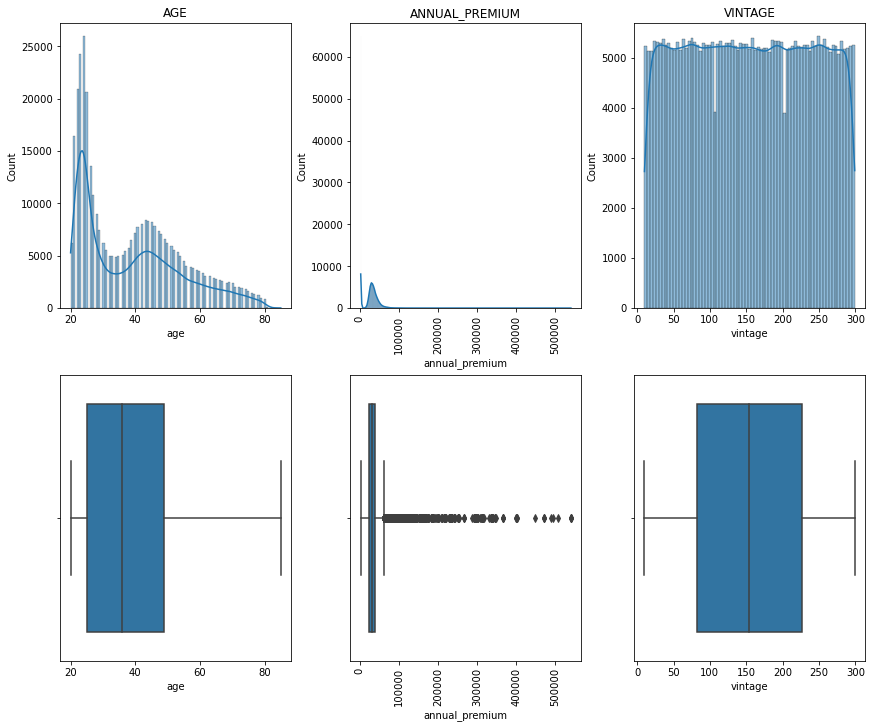

In [35]:
# create a figure object
fig = plt.figure( figsize = (12, 10) , constrained_layout = True )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 3, nrows = 2, figure = fig)

# check age distribution
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
numerical_plot( num_attributes, 'age', ax1, ax2 )

# check annual premium distribution
ax3 = fig.add_subplot( specs[0, 1] )
ax4 = fig.add_subplot( specs[1, 1] )
numerical_plot( num_attributes, 'annual_premium', ax3, ax4,
                hist_label_rot = 90, box_label_rot = 90)

# check vintage distribution
ax5 = fig.add_subplot( specs[0, 2] )
ax6 = fig.add_subplot( specs[1, 2] )
numerical_plot( num_attributes, 'vintage', ax5, ax6 )

### 1.4.2 Categorical Attributes

In [40]:
# check categorical dataframe
print( f'Categorical dataframe has {cat_attributes.shape} shape' )
cat_attributes.head()


Categorical dataframe has (381109, 8) shape


,gender,region_code,policy_sales_channel,previously_insured,response,driving_license,vehicle_damage,vehicle_age
0,Male,28.0,26.0,0,1,1,Yes,> 2 Years
1,Male,3.0,26.0,0,0,1,No,1-2 Year
2,Male,28.0,26.0,0,1,1,Yes,> 2 Years
3,Male,11.0,152.0,1,0,1,No,< 1 Year
4,Female,41.0,152.0,1,0,1,No,< 1 Year


In [41]:
# number of unique values for every column
cat_attributes.apply( lambda x: x.unique() )

gender                                                     [Male, Female]
region_code             [28.0, 3.0, 11.0, 41.0, 33.0, 6.0, 35.0, 50.0,...
policy_sales_channel    [26.0, 152.0, 160.0, 124.0, 14.0, 13.0, 30.0, ...
previously_insured                                                 [0, 1]
response                                                           [1, 0]
driving_license                                                    [1, 0]
vehicle_damage                                                  [Yes, No]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
dtype: object

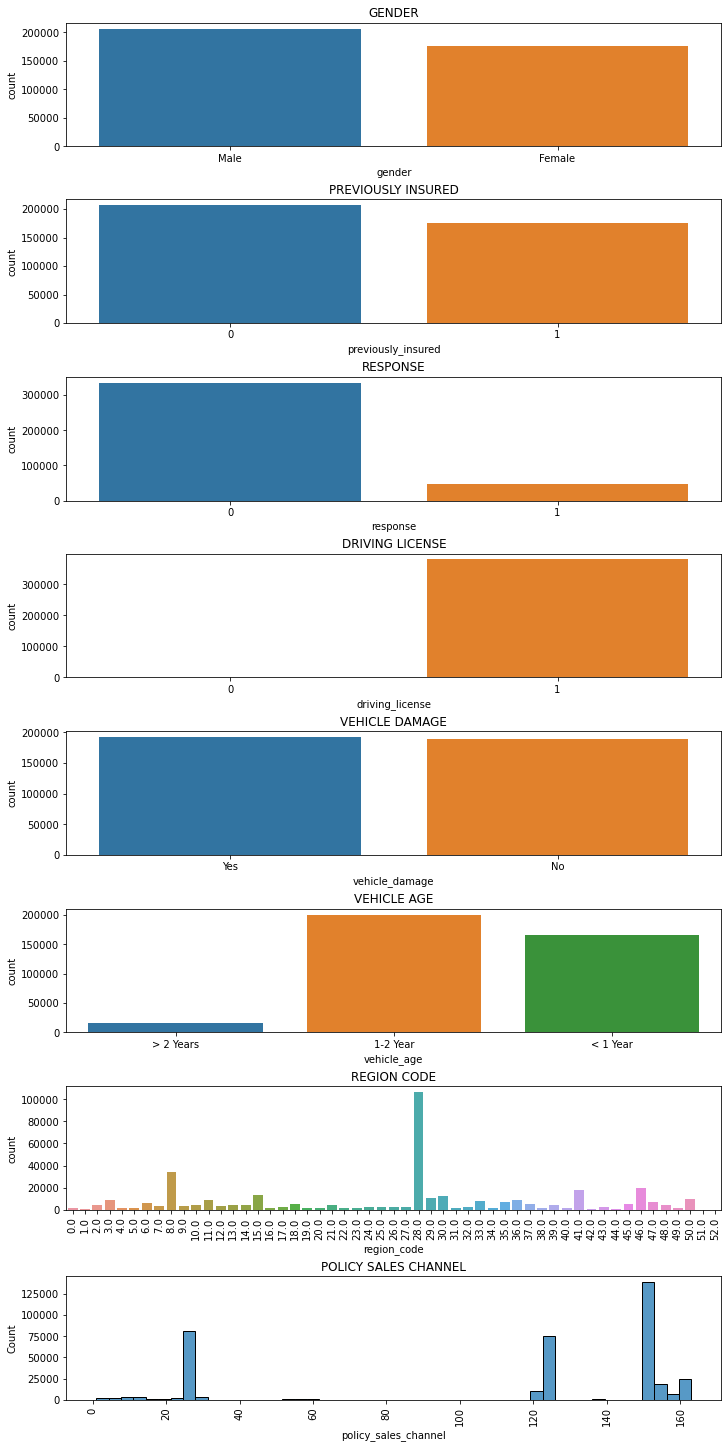

In [42]:
# create a figure object
fig = plt.figure( figsize = (10, 20), constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 8, figure = fig)

# check gender distribution
ax1 = fig.add_subplot( specs[0, 0] )
cat_count_plotting( cat_attributes, 'gender', ax1 )
    
# check previously_insured distribution
ax2 = fig.add_subplot( specs[1, 0] )
cat_count_plotting( cat_attributes, 'previously_insured', ax2 )

# check response distribution
ax3 = fig.add_subplot( specs[2, 0] )
cat_count_plotting( cat_attributes, 'response', ax3 )

# check driving license distribution
ax4 = fig.add_subplot( specs[3, 0] )
cat_count_plotting( cat_attributes, 'driving_license', ax4 )

# check vehicle damage distribution
ax5 = fig.add_subplot( specs[4, 0] )
cat_count_plotting( cat_attributes, 'vehicle_damage', ax5 )

# check vehicle age distribution
ax6 = fig.add_subplot( specs[5, 0] )
cat_count_plotting( cat_attributes, 'vehicle_age', ax6 )

# check region code distribution
ax7 = fig.add_subplot( specs[6, 0] )
cat_count_plotting( cat_attributes, 'region_code', ax7, x_label_rotation = True )

# check policy sales channel distribution
ax8 = fig.add_subplot( specs[7, 0] )
sns.histplot(x = 'policy_sales_channel', data = cat_attributes, ax = ax8)
ax8.set_title( 'POLICY SALES CHANNEL' )
plt.xticks(rotation=90);

# 2.0 Feature Engeneering

In [44]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map

### Automobile hypothesis

1. Os clientes com CNH estão mais interessados no seguro automóvel

2. Quanto maior o preço do veículo, maior o interesse do cliente pelo seguro automóvel

3. Quanto mais velho o carro, menos interessado o cliente está no seguro automóvel

4. Clientes que já tiveram seu veículo danificado no passado estão mais interessados no seguro automóvel

5. O interesse do cliente no seguro automóvel depende do modelo do veículo

### Customer hypothesis

1. O interesse do cliente no seguro automóvel depende da sua profissão

2. O interesse do cliente no seguro automóvel depende da região onde mora

3. Quanto mais velho o cliente, mais interessado ele/ela está no seguro automóvel

4. As mulheres estão mais interessadas em seguro automóvel do que os homens

5. Quanto maior o salário do cliente, mais interessado ele está no seguro automóvel

### Company hypothesis

1. Quanto mais renome a empresa tiver, mais interessado será o cliente

2. Quanto melhores forem as experiências/avaliações do usuário, mais interessados serão os clientes

3. Quanto mais dinheiro uma empresa investir em marketing, terá mais clientes interessados

4. Quanto maior a empresa, mais clientes interessados estarão

5. Quanto mais antiga a empresa, mais clientes interessados estarão

### Insurance hypothesis

1. Quanto mais caro o preço do seguro, menos interessados ​​estarão os clientes

2. Quanto maior a cobertura do seguro, mais interessados ​​estarão os clientes

3. O interesse do cliente depende do canal em que foi contatado pela empresa

4. Diferentes canais de vendas têm uma grande variação em termos de número de clientes interessados

5. Quanto mais regiões geográficas o seguro puder cobrir, maior será o interesse do cliente

6. Se o cliente já contratou seguro de automóvel no passado, é mais provável que ele se interesse por outro seguro de automóvel

7. Se o cliente já contratou seguro de automóvel no passado, ele estaria mais interessado em outro seguro de automóvel se pagasse um preço de prêmio menor no contrato anterior

8. Se o cliente já contratou seguro de automóvel no passado, seu interesse em outro seguro de automóvel depende de qual empresa ele contratou no passado

9. Se o cliente já contratou seguro de automóvel no passado, seu interesse em outro seguro de automóvel depende de quanto tempo o contrato anterior foi

10. Se o cliente já contratou seguro de automóvel no passado, seu interesse em outro seguro de automóvel depende de qual foi sua experiência com o serviço no passado

11. Se o cliente já contratou seguro automóvel no passado, o seu interesse em outro seguro automóvel depende de ter tido que utilizar o serviço de seguro no passado

12. Se o cliente já contratou seguro automóvel no passado, o seu interesse em outro seguro automóvel depende de ter tido que utilizar o serviço de seguro no passado

13. Se o cliente já contratou outros tipos de seguro no passado, é mais provável que ele se interesse pelo seguro de automóvel

14. Se o cliente já havia contratado outros tipos de seguro no passado, ele estaria mais interessado em seguro de automóvel se pagasse um preço de prêmio menor no contrato anterior

15. Se o cliente já contratou outros tipos de seguro no passado, seu interesse em seguro de automóvel depende de qual empresa ele contratou (os outros tipos de seguro) no passado

16. Caso o cliente já tenha contratado outros tipos de seguro no passado, seu interesse no seguro de automóvel depende de quanto tempo o contrato anterior foi

17. Caso o cliente já tenha contratado outros tipos de seguro no passado, seu interesse pelo seguro de automóvel depende de qual foi sua experiência com o serviço no passado

18. Caso o cliente já tenha contratado outros tipos de seguro no passado, o seu interesse no seguro automóvel depende de ter tido que utilizar o serviço de seguro no passado

**O critério escolhido para selecionar a lista final de hipóteses: disponibilidade de dados para testar uma hipótese.**

#### FINAL HYPOTHESIS LIST

H1. Considerando as pessoas interessadas em seguro automóvel, a maioria possui carta de condução.

H2. Considerando as pessoas interessadas em seguros de automóveis, a maioria possui carros mais novos.

H3. Considerando as pessoas interessadas em seguro de automóvel, a maioria teve seu veículo danificado no passado.

H4. Considerando as pessoas interessadas em seguro de automóvel, o número de clientes interessados em seguro de automóvel tem uma grande variação de acordo com a região do cliente.

H5. Considerando as pessoas interessadas em seguro de automóvel, a maioria delas é mais velha do que mais jovem.

H6. Considerando as pessoas interessadas em seguros de automóveis, a maioria são mulheres.

H7. Diferentes canais de vendas têm uma grande variação em termos de número de clientes interessados.

H8. Considerando as pessoas interessadas em seguro de automóvel, a maioria já havia contratado seguro de automóvel no passado.

H9. Considerando as pessoas interessadas em seguro de automóvel, a maioria contratou seguro saúde mais barato no passado.

H10. Considerando as pessoas interessadas em seguro de automóvel, a maioria delas havia contratado seguro saúde por um período maior de tempo.

## 2.2 Feature Engineering

In [46]:
# check dataframe
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [28]:
# Change age column
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                 if x == '1-2 Year' else 'below_1_year' ) 
# convert damage column from Yes-No to 1-0 
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x:1 if x == 'Yes' else 0 )

# 3.0  Data Filtering

In [30]:
df3= df2.copy()

Pela análise das Features e as restrições de negócio, nesse primeiro ciclo não será necessário filtrar nenhuma variável.

# 4.0 EDA

In [31]:
df4 = df3.copy()

## 4.1 Univariate Analysis

<AxesSubplot:xlabel='response', ylabel='count'>

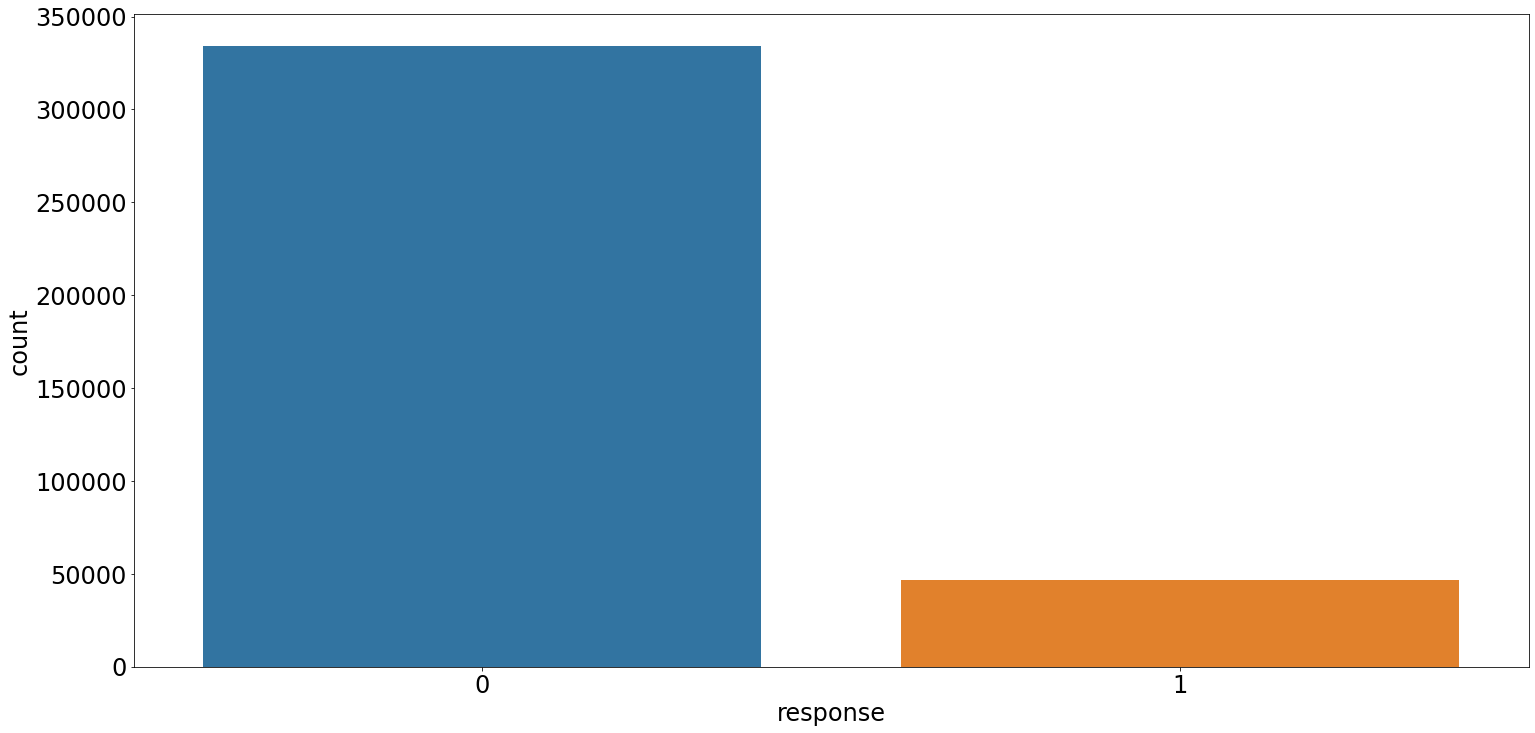

In [165]:
# plot response variable
sns.countplot( x = 'response', data = df4 )

### Numerical variables

In [52]:
# select numerical features
num_features = df4[ ['age', 
                     'annual_premium',
                     'vintage'] ]

num_features.sample( 5 )

,age,annual_premium,vintage
198947,55,45601.0,196
226712,21,21287.0,287
9752,47,41878.0,264
193720,25,39443.0,213
351756,41,2630.0,99


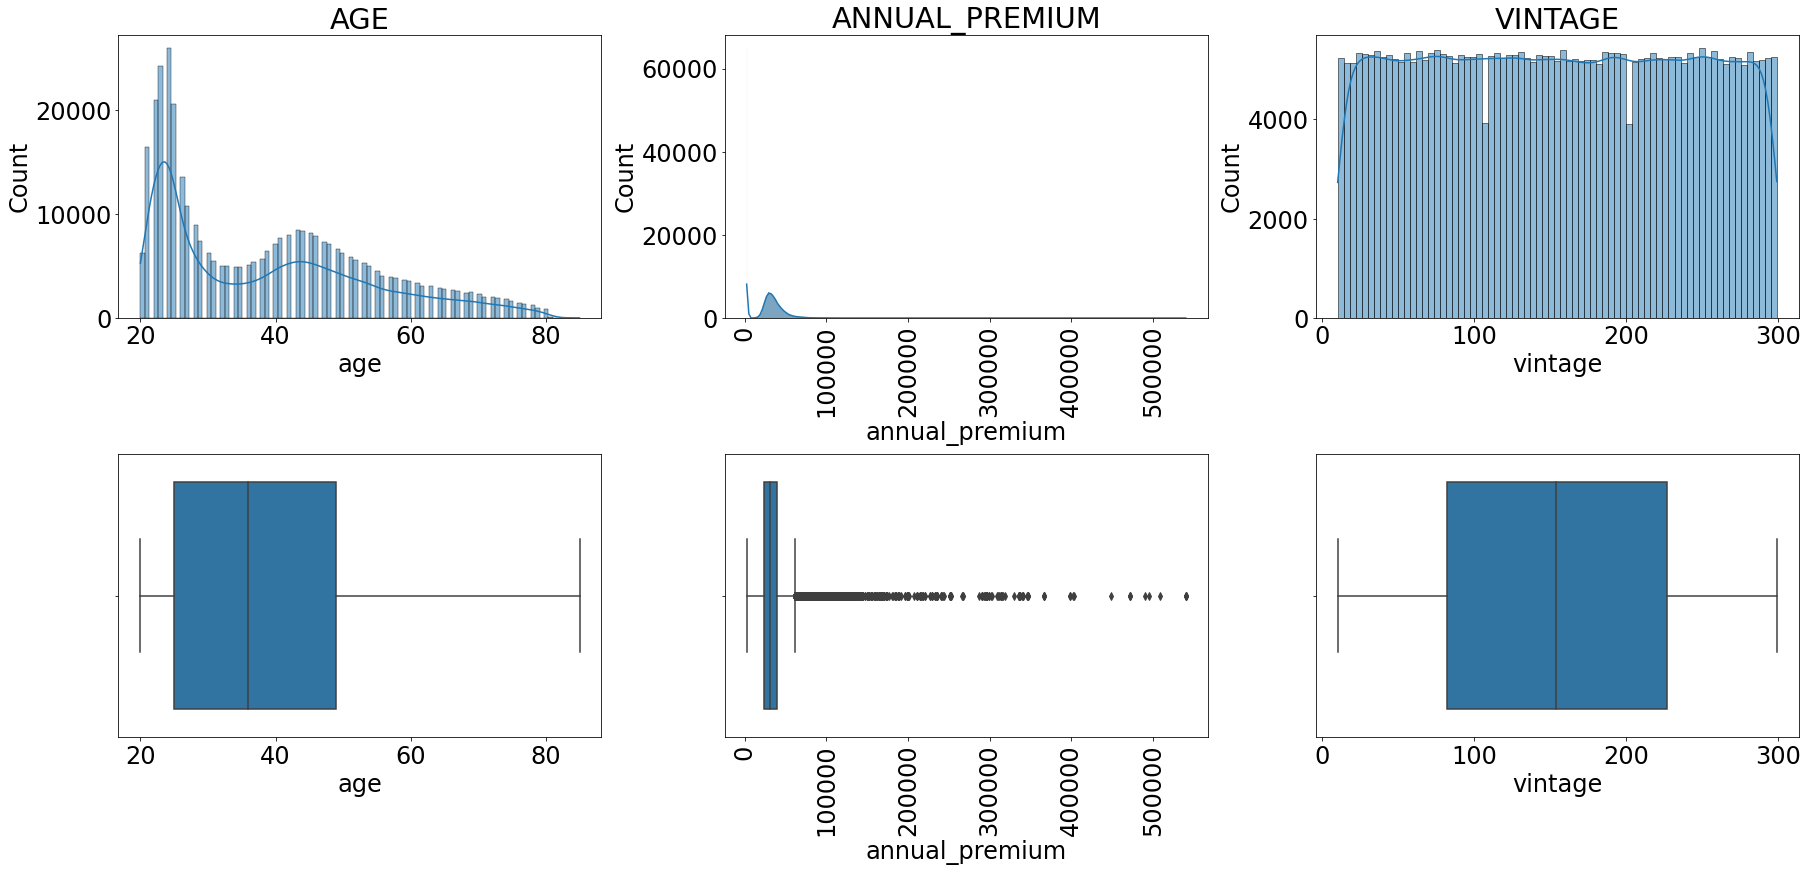

In [166]:
# create a figure object
fig = plt.figure( constrained_layout = True)

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 3, nrows = 2, figure = fig)

# check age distribution
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
numerical_plot( num_features, 'age', hist_axs = ax1 , box_axs = ax2 )

# check annual premium distribution
ax3 = fig.add_subplot( specs[0, 1] )
ax4 = fig.add_subplot( specs[1, 1] )
numerical_plot( num_features, 'annual_premium', hist_axs = ax3 , box_axs = ax4,
                hist_label_rot = 90, box_label_rot = 90 )

# check vintage distribution
ax5 = fig.add_subplot( specs[0, 2] )
ax6 = fig.add_subplot( specs[1, 2] )
numerical_plot( num_features, 'vintage', hist_axs = ax5 , box_axs = ax6 )

In [61]:
# calculate summary statistics
numerical_statistics( num_features )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,age,38.823,36.000,15.512,20.000,85.000,65.000,0.673,-0.566
1,annual_premium,30564.390,31669.000,17213.132,2630.000,540165.000,537535.000,1.766,34.005
2,vintage,154.347,154.000,83.671,10.000,299.000,289.000,0.003,-1.201


### Categorical variables

In [62]:
# select categorical features
cat_features = df4[ ['gender', 
                     'region_code', 
                     'policy_sales_channel',
                     'previously_insured',
                     'driving_license',
                     'vehicle_age',
                     'vehicle_damage'] ]

cat_features.head()

,gender,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_age,vehicle_damage
0,Male,28.000,26.000,0,1,over_2_years,1
1,Male,3.000,26.000,0,1,between_1_2_year,0
2,Male,28.000,26.000,0,1,over_2_years,1
3,Male,11.000,152.000,1,1,below_1_year,0
4,Female,41.000,152.000,1,1,below_1_year,0


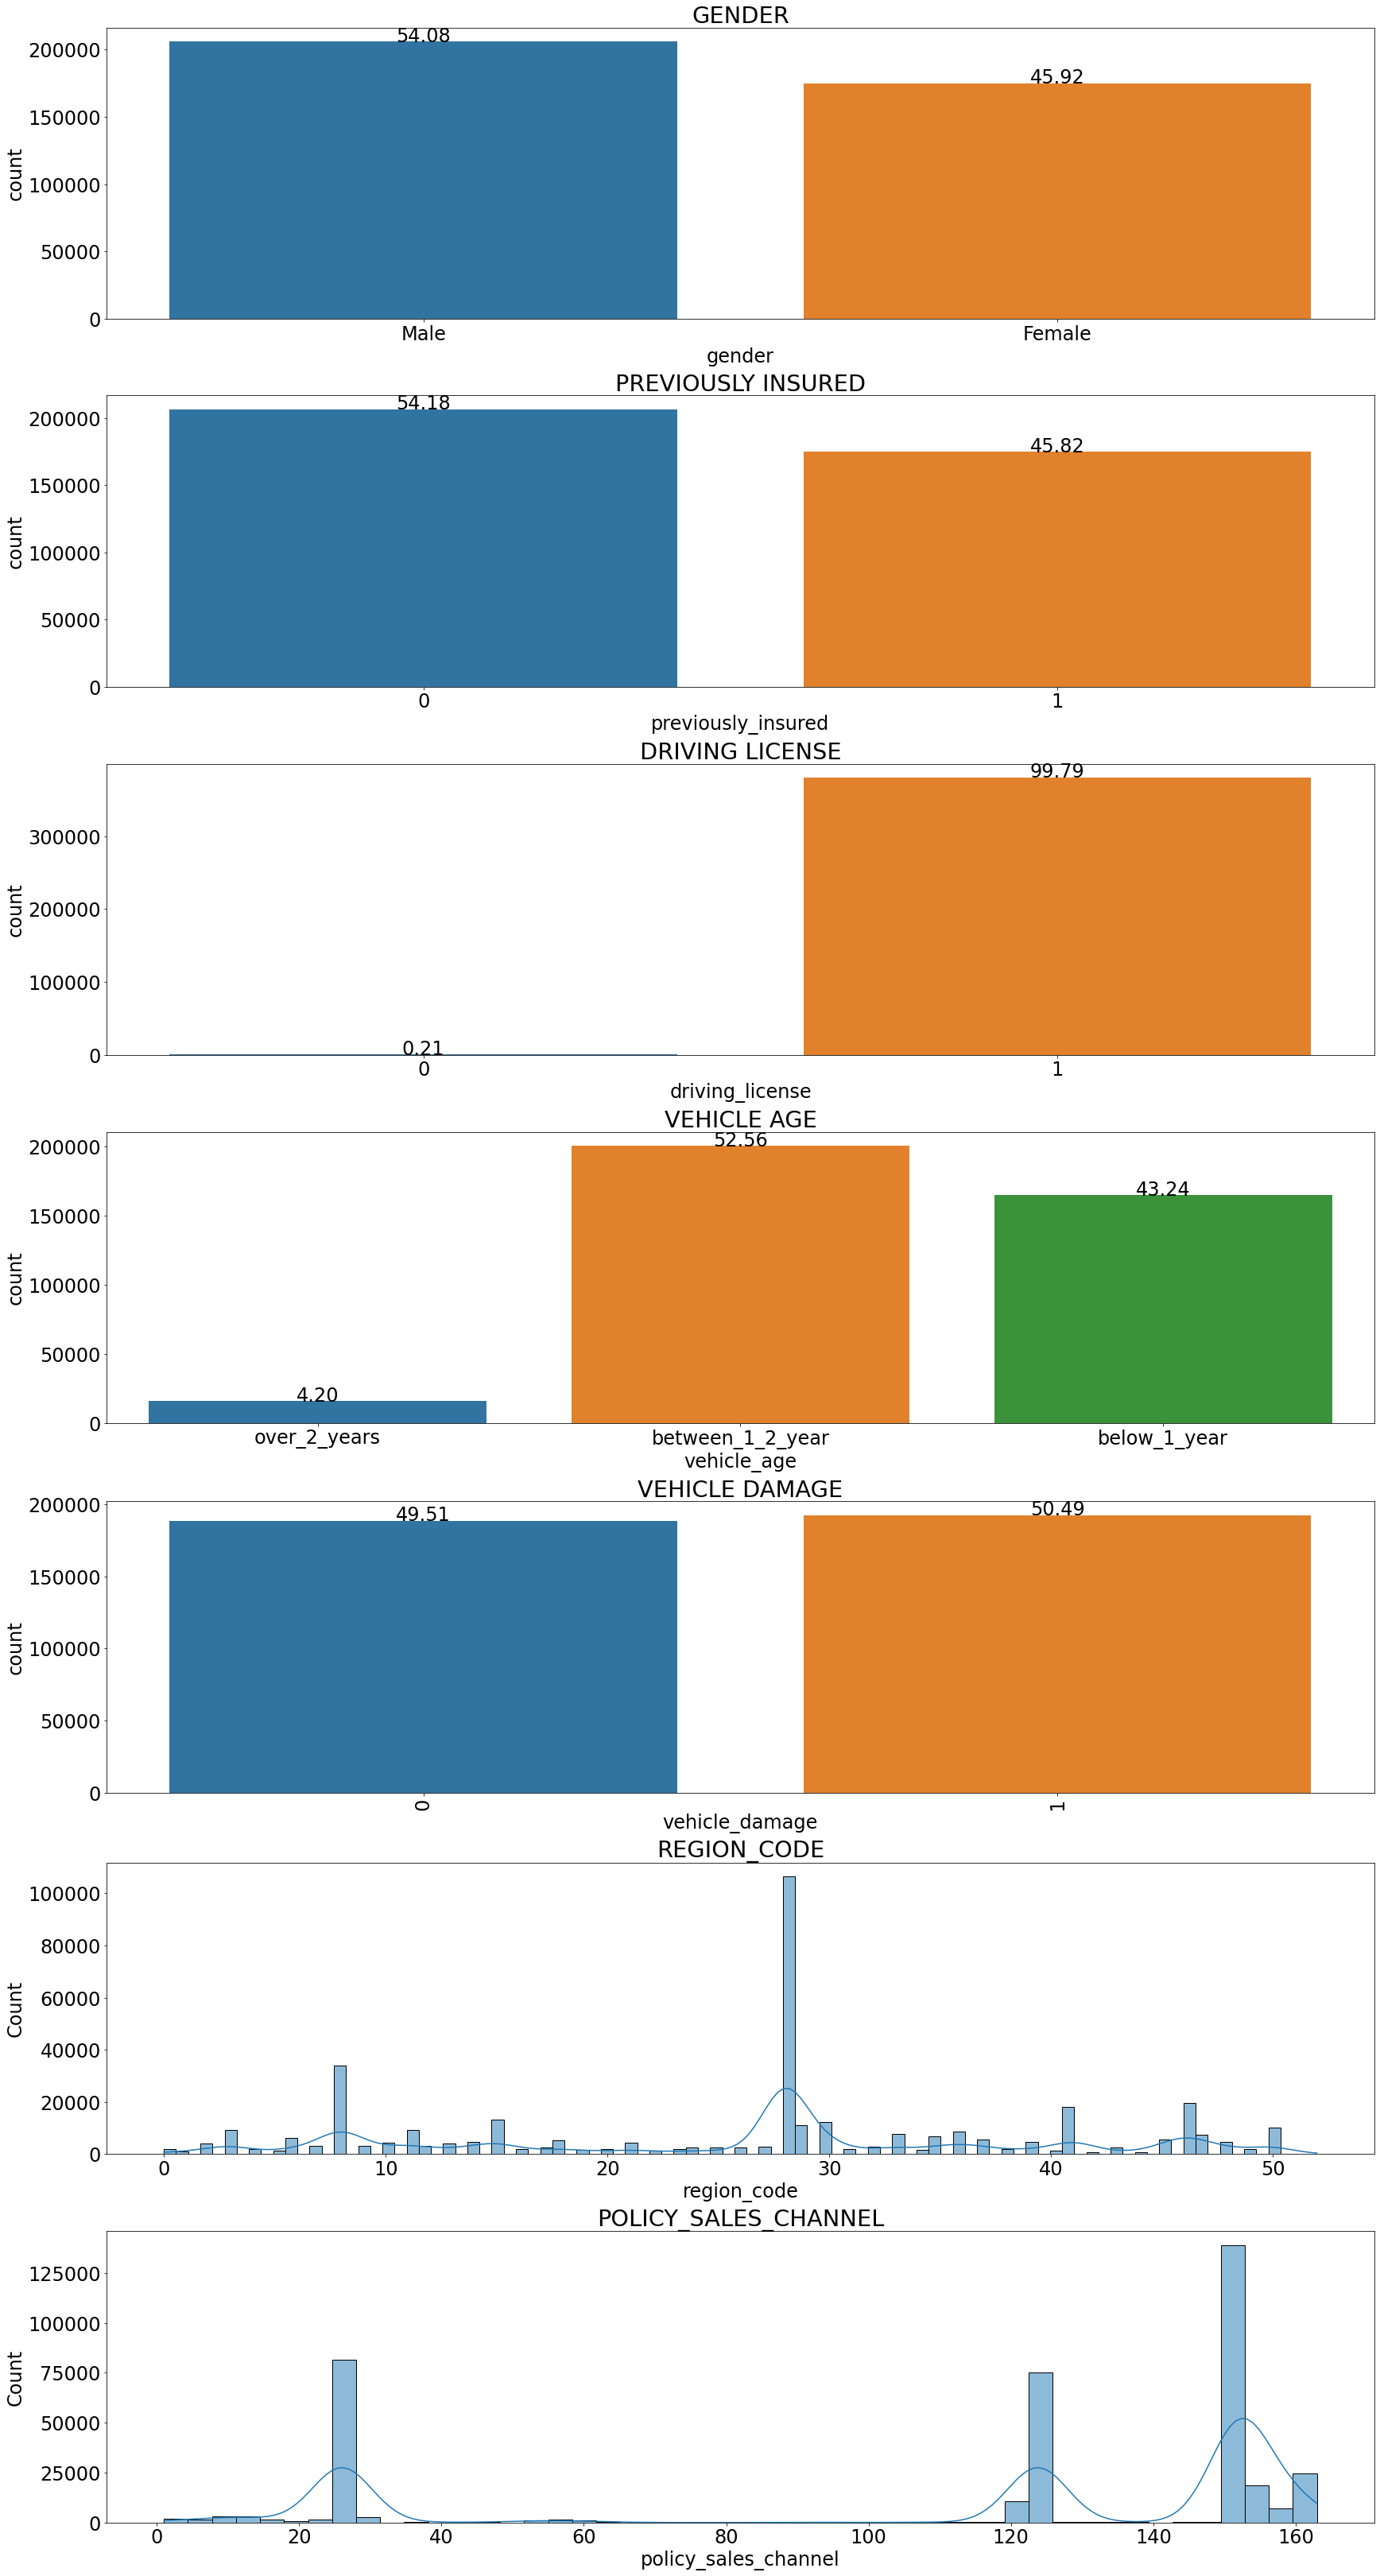

In [63]:
# create a figure object
fig = plt.figure( figsize = (24, 50),  constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 8, figure = fig)

# check gender distribution
ax1 = fig.add_subplot( specs[0, 0] )
cat_count_plotting( cat_features, 'gender', ax1 )
    
# check previously_insured distribution
ax2 = fig.add_subplot( specs[1, 0] )
cat_count_plotting( cat_features, 'previously_insured', ax2 )

# check driving_license distribution
ax3 = fig.add_subplot( specs[2, 0] )
cat_count_plotting( cat_features, 'driving_license', ax3 )

# check vehicle_age distribution
ax4 = fig.add_subplot( specs[3, 0] )
cat_count_plotting( cat_features, 'vehicle_age', ax4 )

# check vehicle_damage distribution
ax5 = fig.add_subplot( specs[4, 0] )
cat_count_plotting( cat_features, 'vehicle_damage', ax5, x_label_rotation = True )

# check region_code distribution
ax6 = fig.add_subplot( specs[5, 0] )
sns.histplot( data = cat_features, x = 'region_code', ax = ax6, kde = True )
plt.title( 'REGION_CODE' )

# check policy_sales_channel distribution
ax7 = fig.add_subplot( specs[6, 0] )
sns.histplot( data = cat_features, x = 'policy_sales_channel', ax = ax7, kde = True )
plt.title( 'POLICY_SALES_CHANNEL' );

812 customers don't have driving license, while  380297 customers have driving license


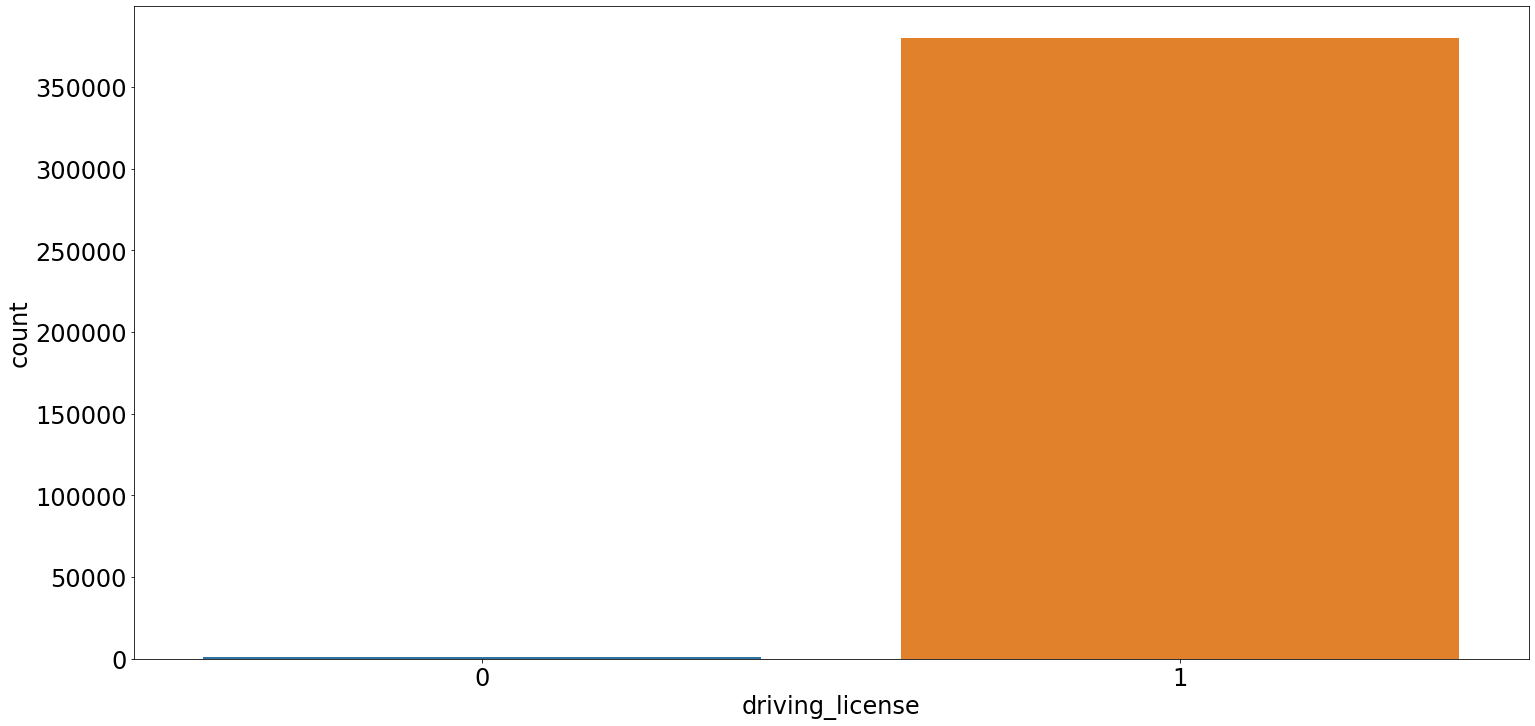

In [64]:
# check driving_license more closely
# display number of occurrences for each value
print( cat_features[ ['driving_license'] ].value_counts()[0], 
       "customers don't have driving license, while ", 
       cat_features[ ['driving_license'] ].value_counts()[1], 
       'customers have driving license' )

# plot countplot again
sns.countplot( data = cat_features, x = 'driving_license' );

## 4.2 Bivariate analyses

### H1. Considerando as pessoas interessadas em seguro automóvel, a maioria possui carta de condução.

**H1 É VERDADEIRO** A maioria das pessoas interessadas em seguro automóvel tem CNH.

In [65]:
# create a cross tabulation with driving_license and response
df_h1 = pd.crosstab( df4['driving_license'], df4['response'], 
                     normalize = 'columns',  margins = True)

df_h1

response,0,1,All
driving_license,,,
0,0.002,0.001,0.002
1,0.998,0.999,0.998


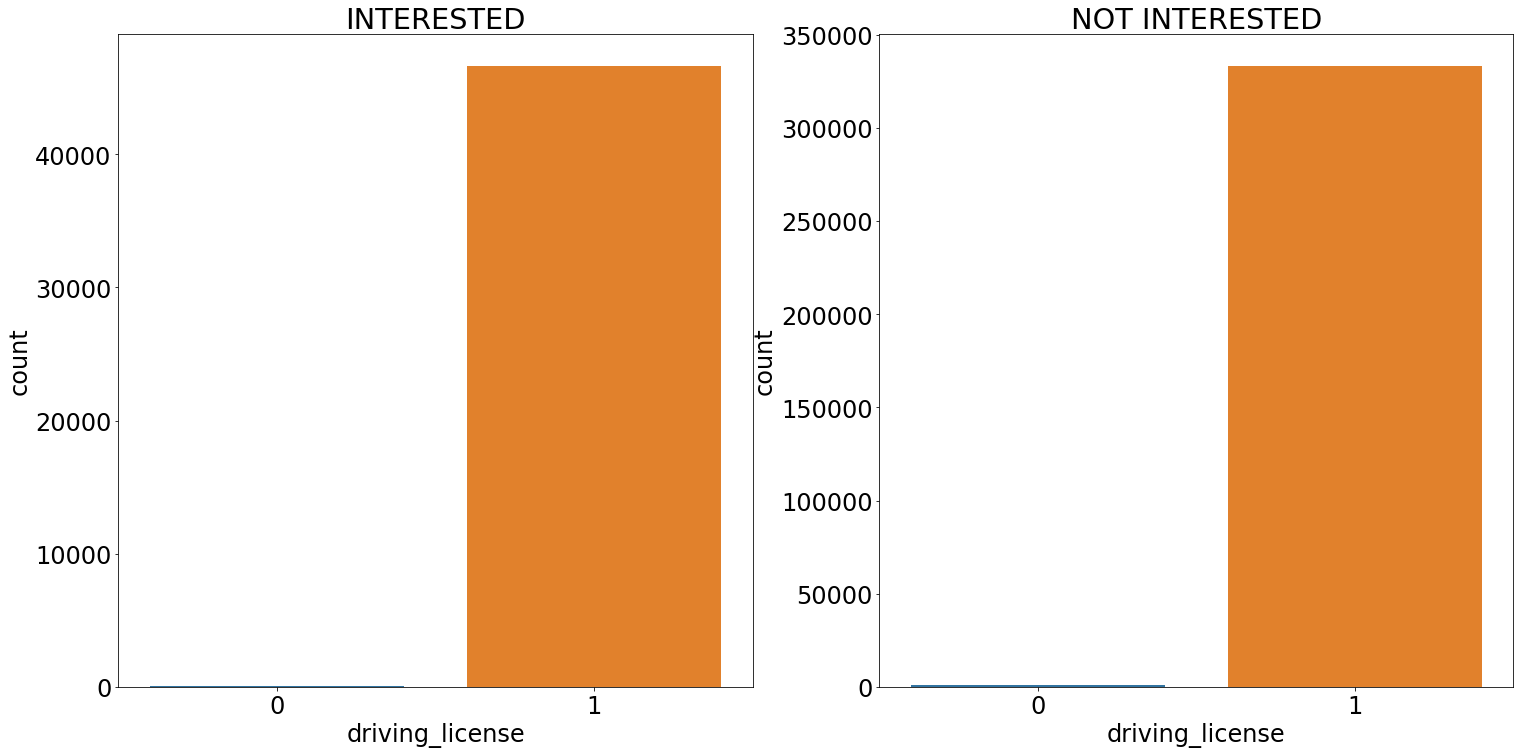

In [66]:
# create subplots for 'interested' and 'not interested'
ax1 = plt.subplot( 1 , 2, 1)
ax2 = plt.subplot( 1 , 2, 2)

# plot 'interested'
sns.countplot( x = 'driving_license', 
              data = df4[df4['response'] == 1], ax = ax1 )
ax1.set_title( 'INTERESTED') 

# plot 'not interested'
sns.countplot( x = 'driving_license', 
              data = df4[df4['response'] == 0], ax = ax2 )
ax2.set_title( 'NOT INTERESTED' );

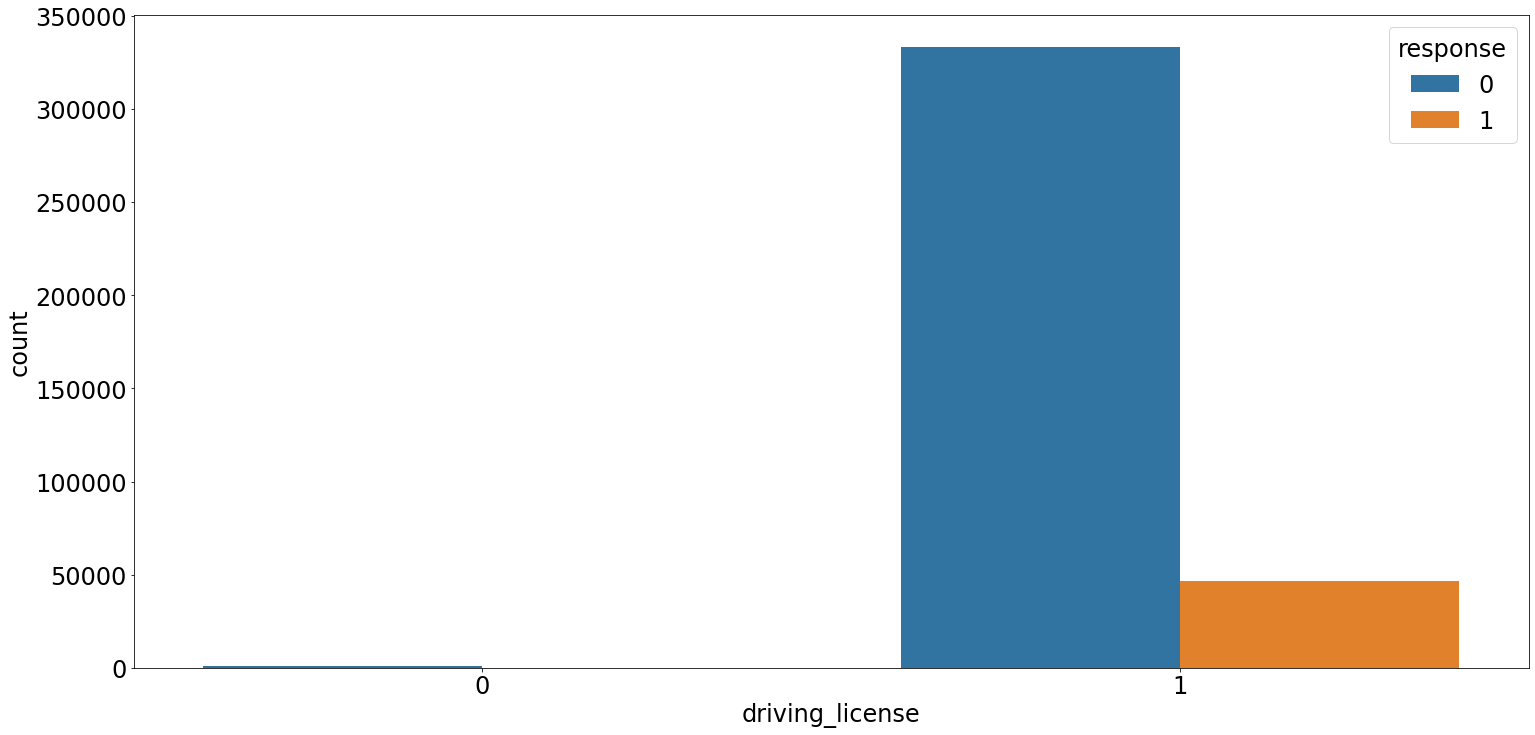

In [67]:
# get intuition about driving_license relevance
sns.countplot( x = 'driving_license', hue = 'response', data = df4);

### H2. Considerando as pessoas interessadas em seguros de automóveis, a maioria possui carros mais novos.

**H2 É VERDADEIRO**. A maioria das pessoas interessadas em seguro automóvel tem carros mais novos.

In [68]:
# create a cross tabulation with vehicle_age and response
df_h2 = pd.crosstab( df4['vehicle_age'], df4['response'],
                     normalize = 'columns')

df_h2

response,0,1
vehicle_age,,
below_1_year,0.471,0.154
between_1_2_year,0.495,0.745
over_2_years,0.034,0.101


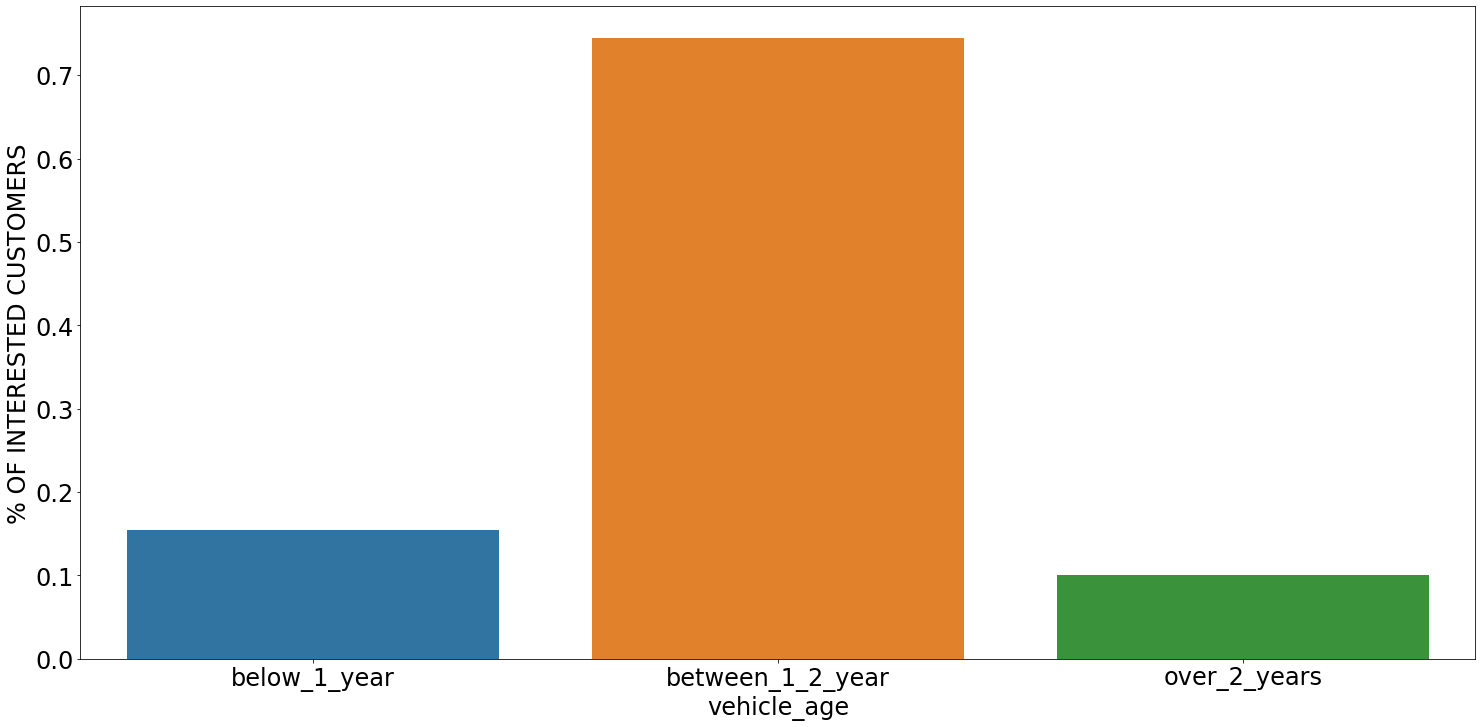

In [69]:
# plot response against vehicle_age
sns.barplot( x = 'vehicle_age', y = 1, data = df_h2.reset_index() )
plt.ylabel('% OF INTERESTED CUSTOMERS');


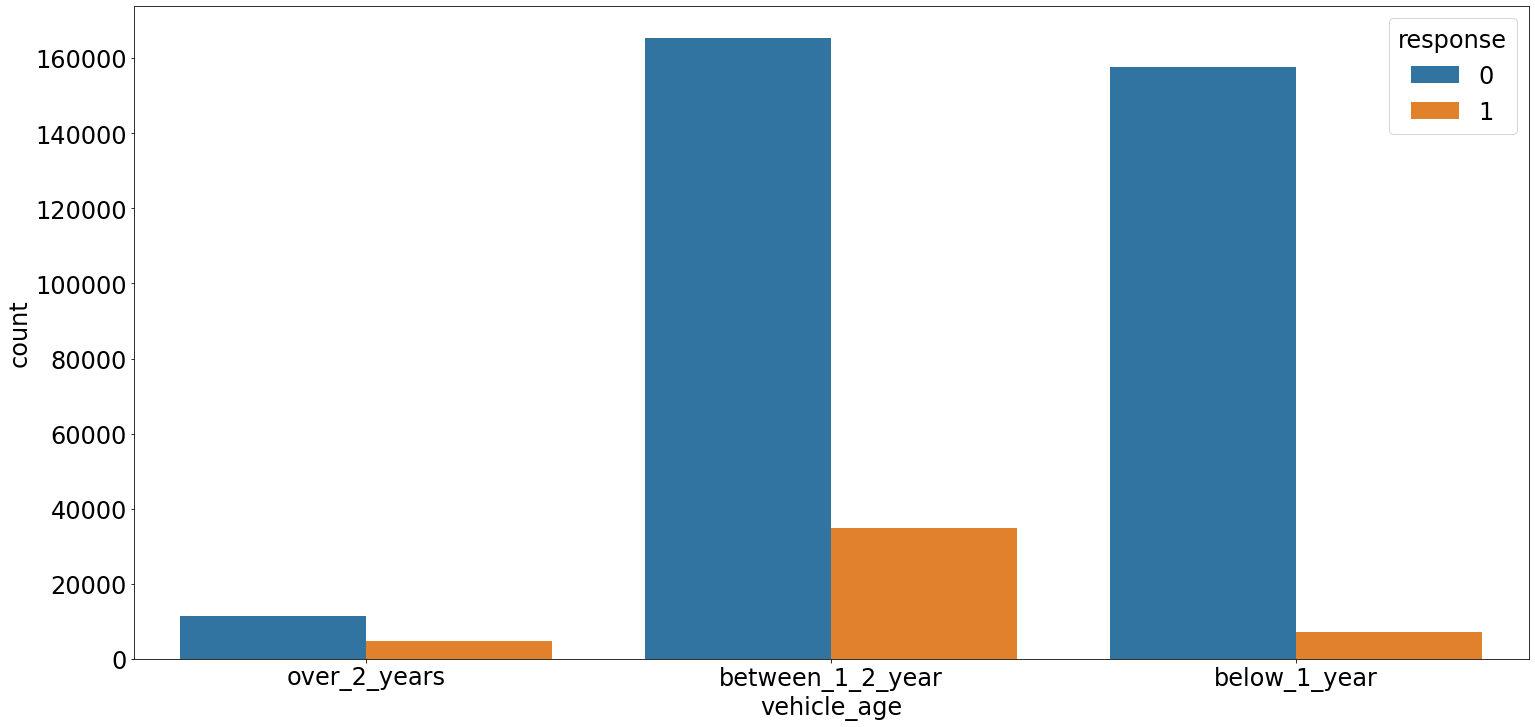

In [70]:
# get intuition about vehicle_age relevance
sns.countplot( x = 'vehicle_age', hue = 'response', data = df4);

### H3. Considerando as pessoas interessadas em seguro de automóvel, a maioria teve seu veículo danificado no passado.

**H3 É VERDADEIRO**. A maioria das pessoas interessadas em seguro de automóvel teve seu veículo danificado no passado.

In [71]:
# create cross tabulation with vehicle_damage and response columns
df_h3 = pd.crosstab( df4['vehicle_damage'], df4['response'], 
                     normalize = 'columns')

df_h3

response,0,1
vehicle_damage,,
0,0.561,0.021
1,0.439,0.979


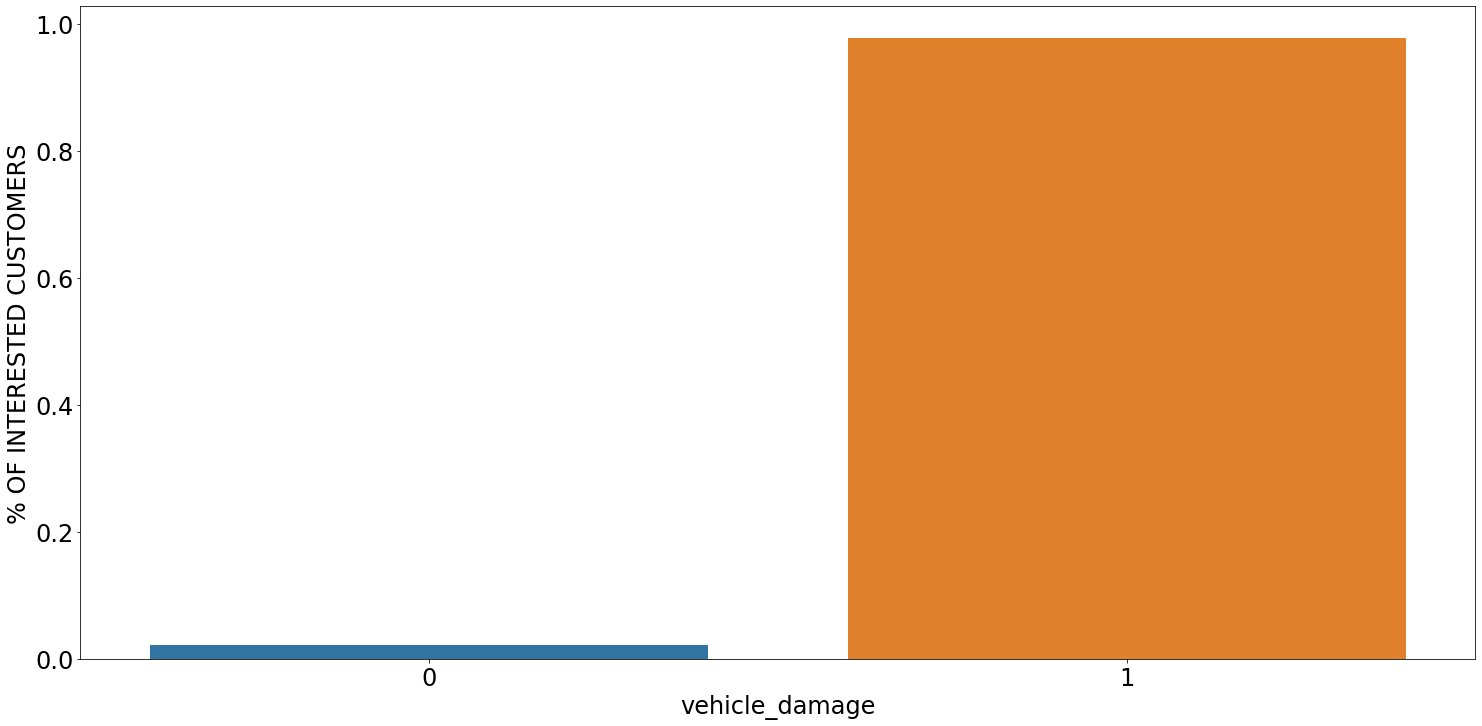

In [72]:
# percentage of interested customers per vihicle_damage category
sns.barplot(x = 'vehicle_damage', y = 1, data = df_h3.reset_index() )
plt.ylabel( '% OF INTERESTED CUSTOMERS' );

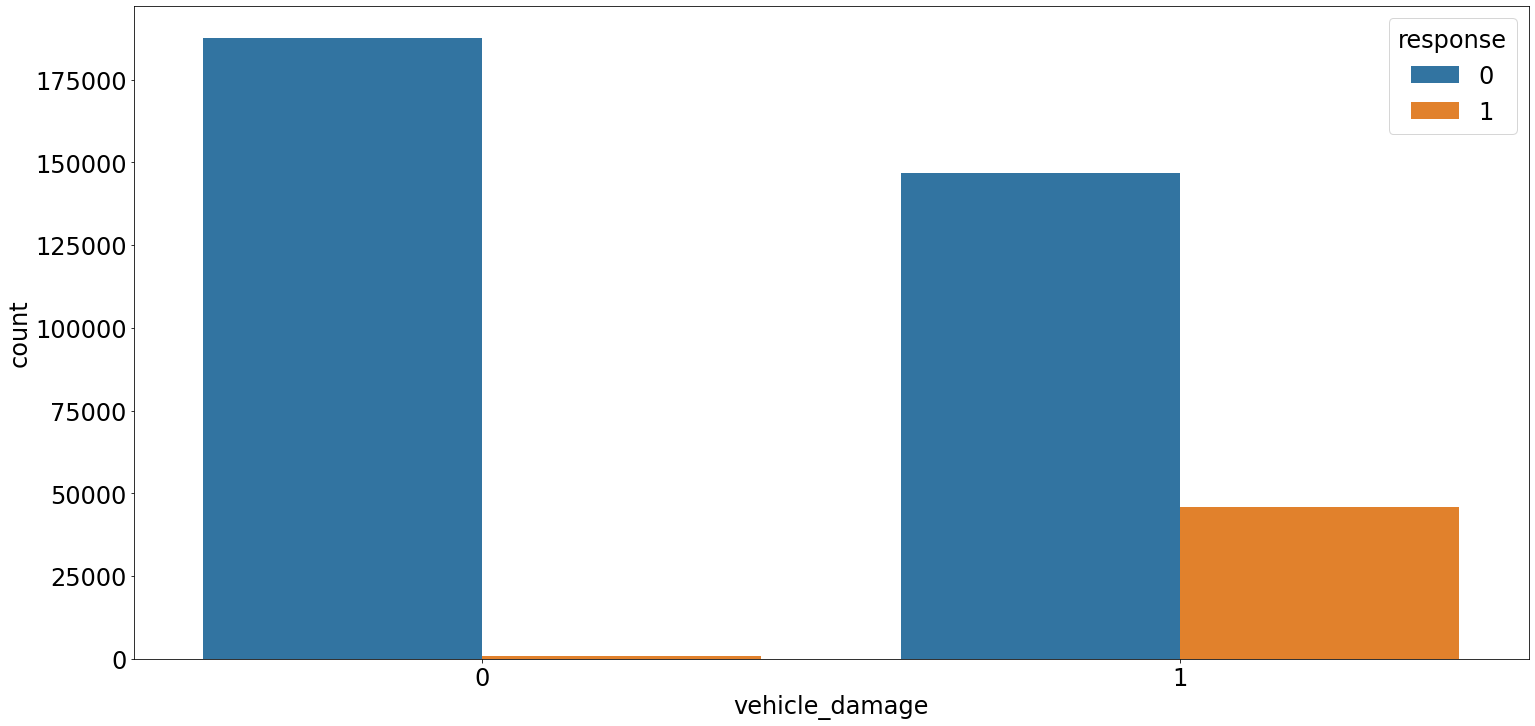

In [74]:
# get intuition about vehicle_damage relevance
sns.countplot( x = 'vehicle_damage', hue = 'response', data = df4);

### H4. Considerando as pessoas interessadas em seguro de automóvel, o número de clientes interessados em seguro de automóvel tem uma grande variação de acordo com a região do cliente.

**H4 É VERDADEIRO**. Diferentes regiões têm uma grande variação em termos de número de clientes interessados.

In [75]:
# create cross tabulation with region_code and response columns
df_h4 = pd.crosstab( df4['region_code'], df4['response'],
                     normalize = 'index' )

df_h4.tail()

response,0,1
region_code,,
48.000,0.898,0.102
49.000,0.925,0.075
50.000,0.937,0.063
51.000,0.847,0.153
52.000,0.876,0.124


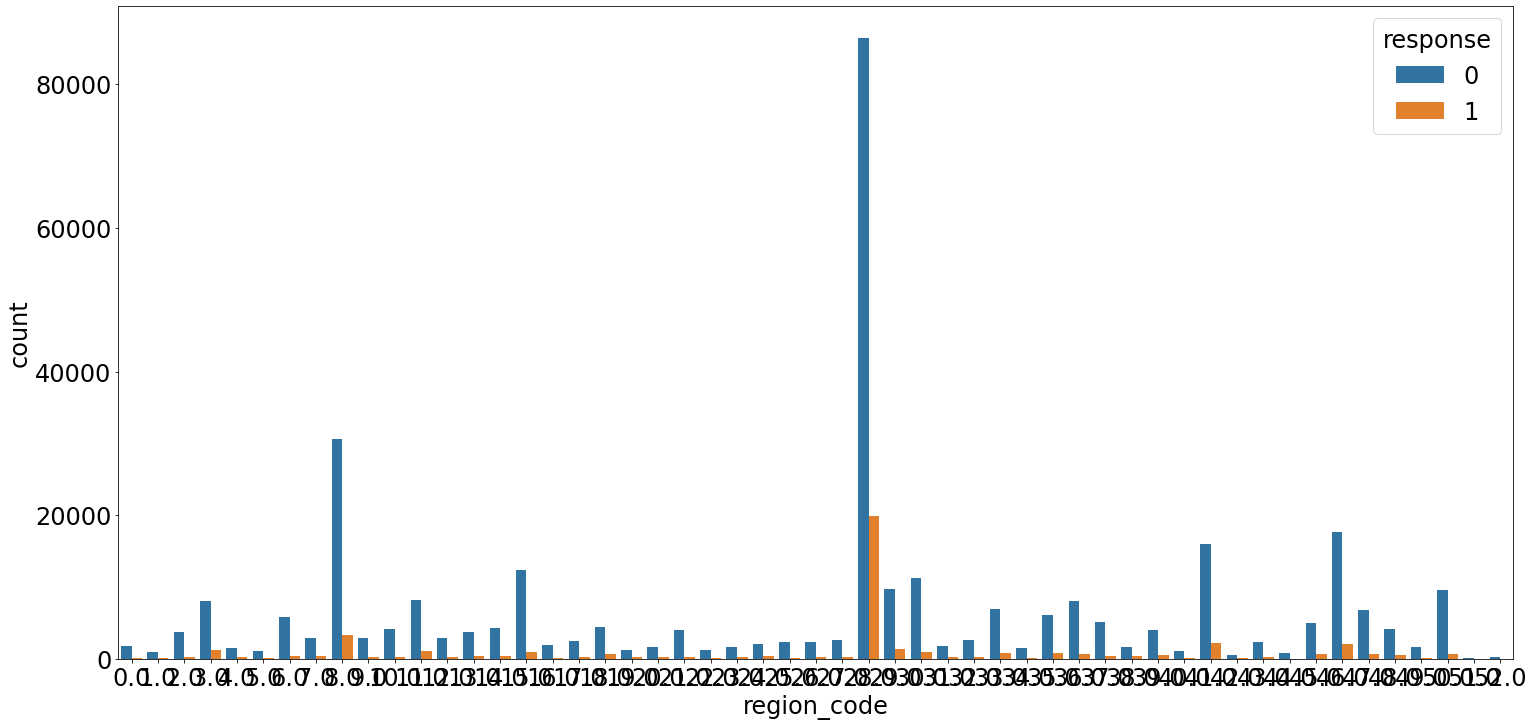

In [167]:
# plot response against region_code
sns.countplot( x = 'region_code', hue = 'response', data = df4);

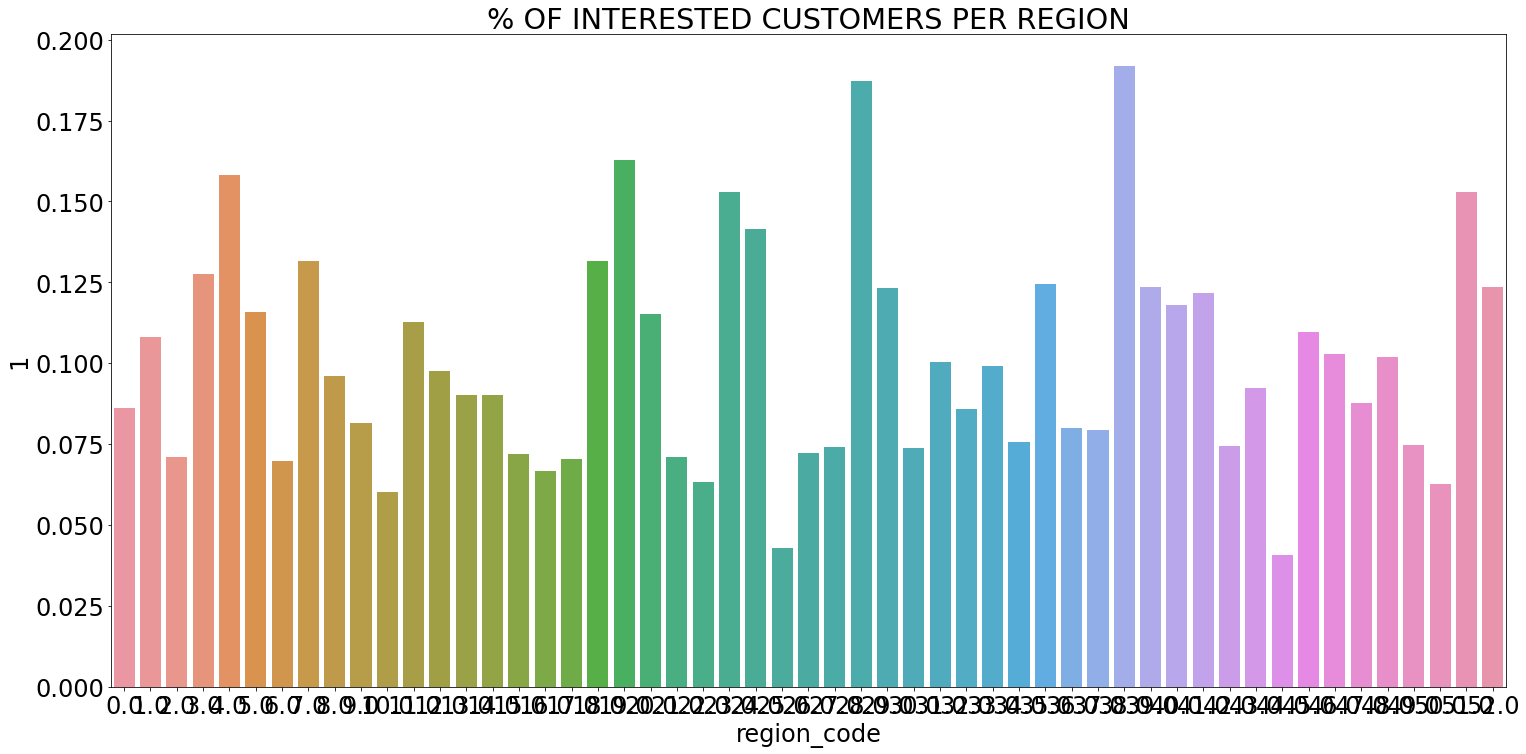

In [168]:
# plot number of interested customers per region_code
sns.barplot( x = 'region_code', y = 1, data = df_h4.reset_index() )
plt.title( '% OF INTERESTED CUSTOMERS PER REGION' );

### H5. Considerando as pessoas interessadas em seguro de automóvel, a maioria delas é mais velha do que mais jovem.

**H5 É FALSO**. A maioria dos clientes interessados tem cerca de 43 anos. Acima e abaixo dessa idade, o número de clientes interessados diminui.

In [81]:
# create cross tabulation with age and response columns
df_h5 = pd.crosstab( df4['age'], df4['response'],
                     normalize = 'columns' )

df_h5.head()

response,0,1
age,,
20,0.018,0.004
21,0.047,0.012
22,0.060,0.016
23,0.070,0.019
24,0.075,0.020


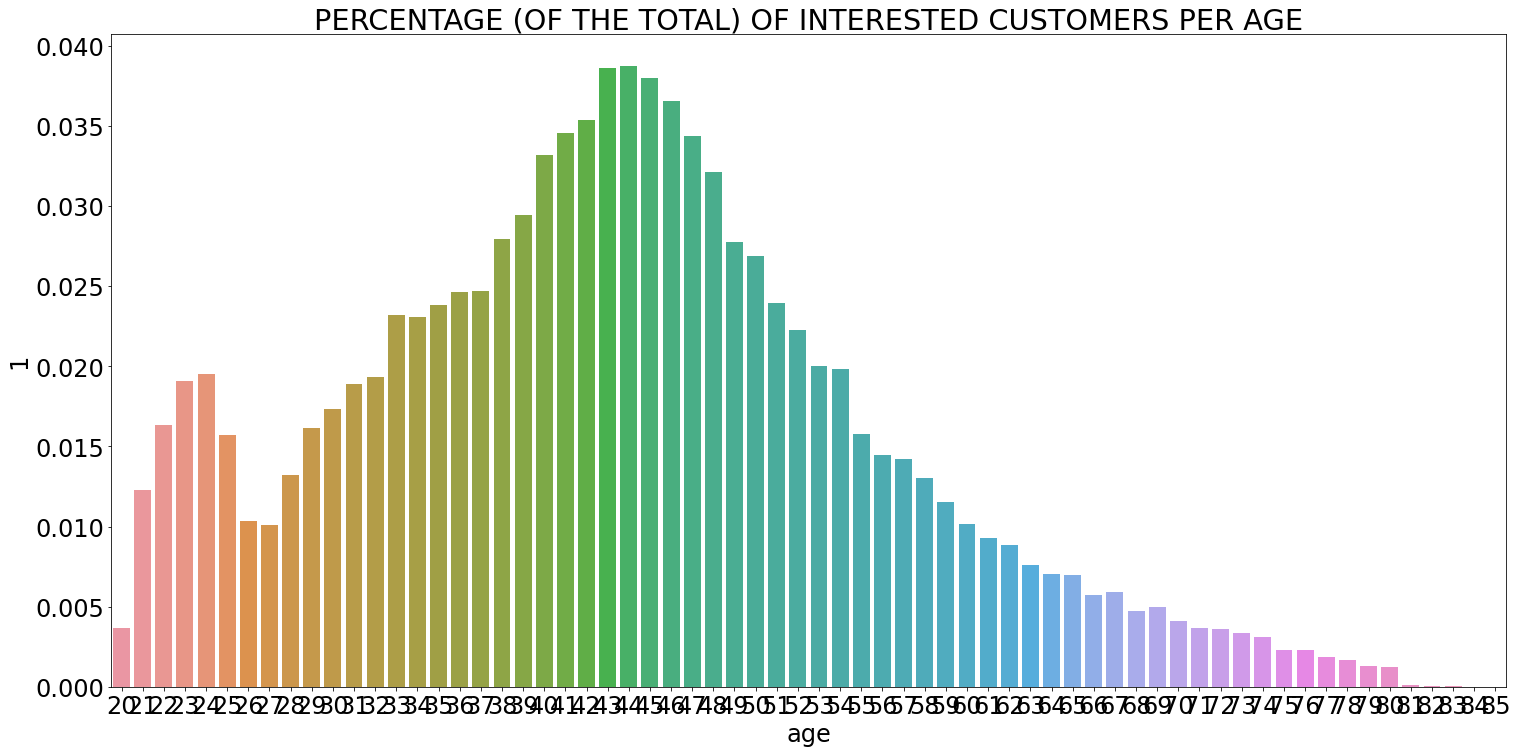

In [82]:
# plot response against percentage of interested customers per age
sns.barplot( x = 'age', y = 1, data = df_h5.reset_index() )
plt.title( 'PERCENTAGE (OF THE TOTAL) OF INTERESTED CUSTOMERS PER AGE' );

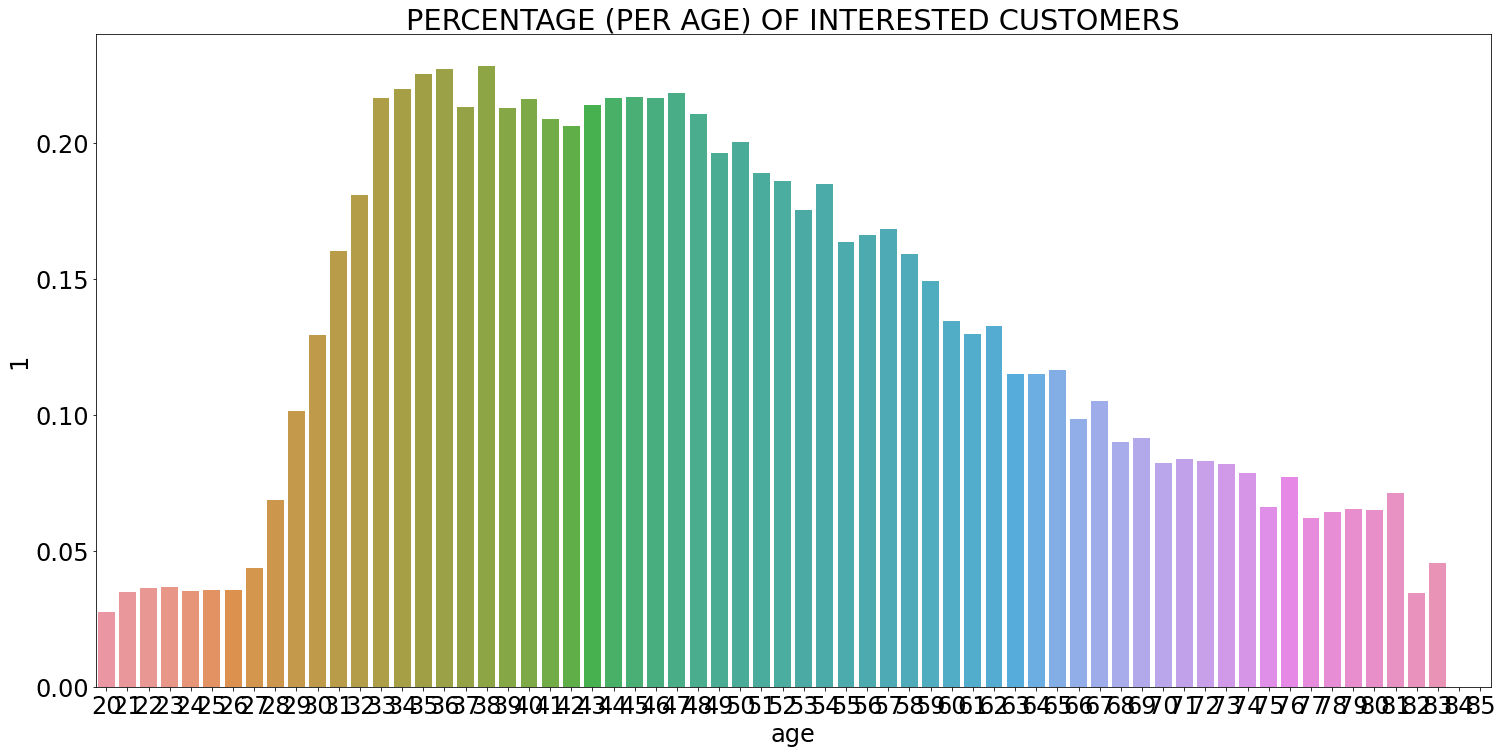

In [87]:
# create auxiliary crosstab with index normalization
df_h5_aux = pd.crosstab( df4['age'], df4['response'],
                     normalize = 'index' )

# plot percentage of interested customers per age
sns.barplot( x = 'age', y = 1, data = df_h5_aux.reset_index() )
plt.title( 'PERCENTAGE (PER AGE) OF INTERESTED CUSTOMERS' );

### H6. Considerando as pessoas interessadas em seguros de automóveis, a maioria são mulheres.

**H6 É FALSO**. Há mais homens interessados em seguro automóvel do que mulheres.

In [89]:
# create cross tabulation with gender and response columns
df_h6 = pd.crosstab( df4['gender'], df4['response'],
                     normalize = 'columns' )

df_h6

response,0,1
gender,,
Female,0.469,0.389
Male,0.531,0.611


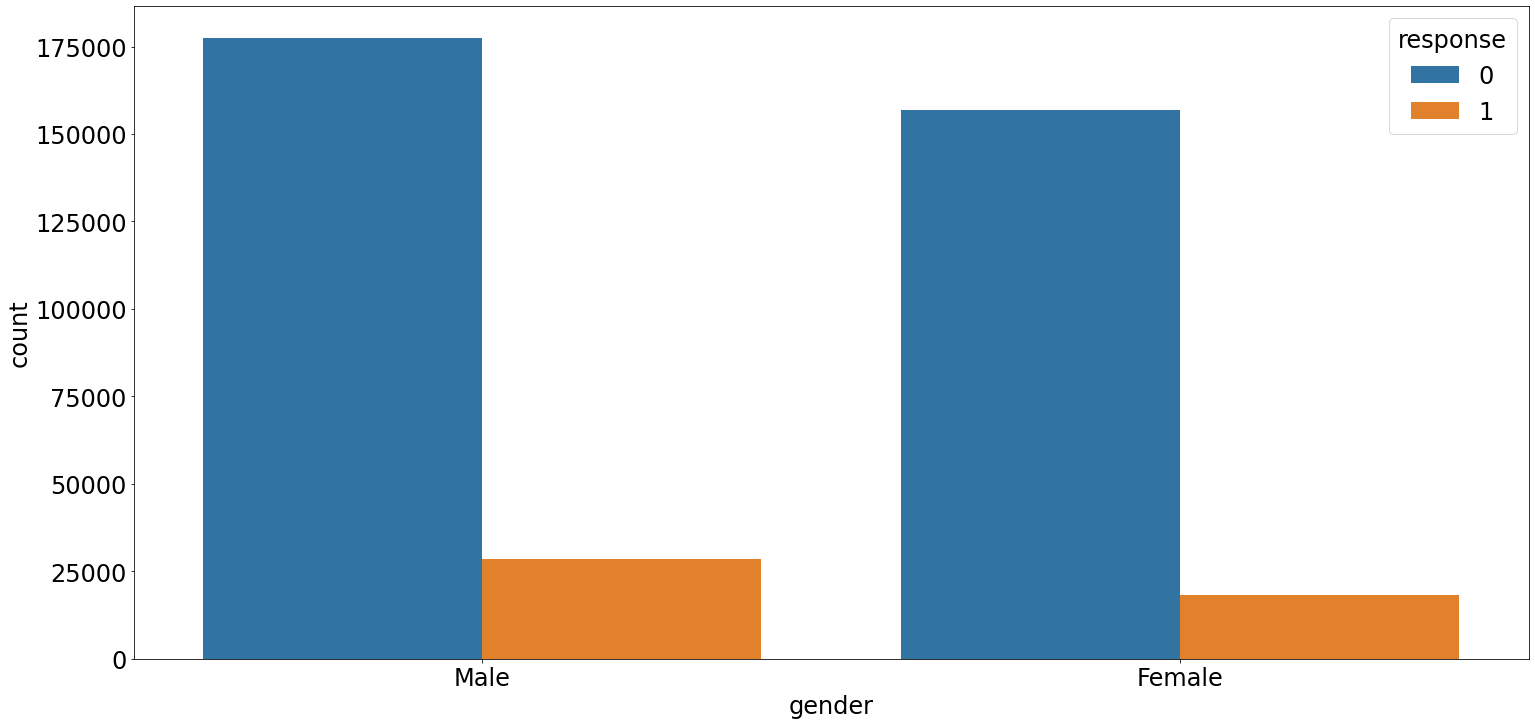

In [90]:
# plot response against gender
sns.countplot( x = 'gender', hue = 'response', data = df4);

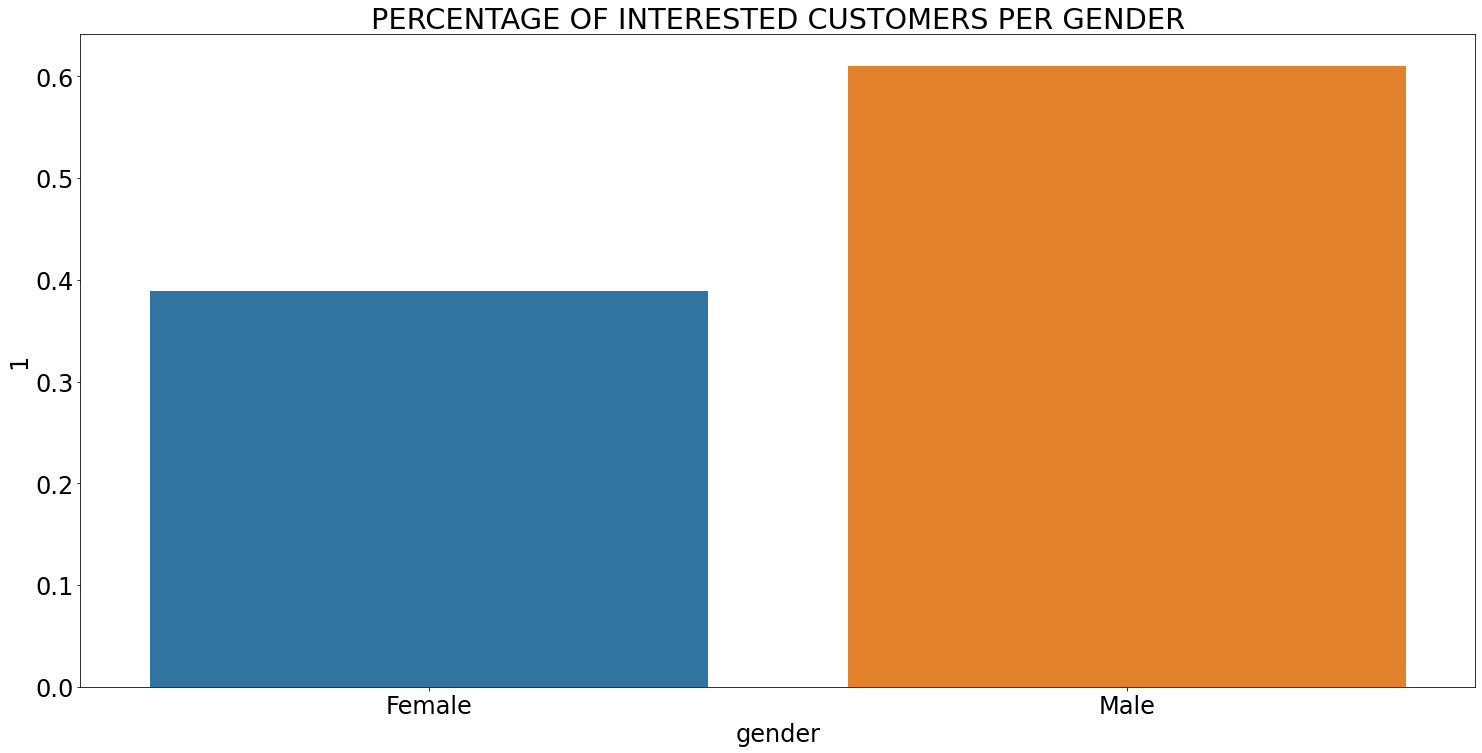

In [91]:
# plot number of interested customers per gender
sns.barplot( x = 'gender', y = 1, data = df_h6.reset_index() )
plt.title( 'PERCENTAGE OF INTERESTED CUSTOMERS PER GENDER' );

### H7. Diferentes canais de vendas têm uma grande variação em termos de número de clientes interessados.

**H7 É VERDADEIRO**. O número de clientes interessados pode variar muito entre os canais de vendas.

In [92]:
# create cross tabulation with policy_sales_channel and response columns
df_h7 = pd.crosstab( df4['policy_sales_channel'], df4['response'],
                     normalize = 'columns' )

df_h7.sample( 5 )

response,0,1
policy_sales_channel,,
133.000,0.000,0.000
13.000,0.005,0.006
98.000,0.000,0.000
92.000,0.000,0.000
69.000,0.000,0.000


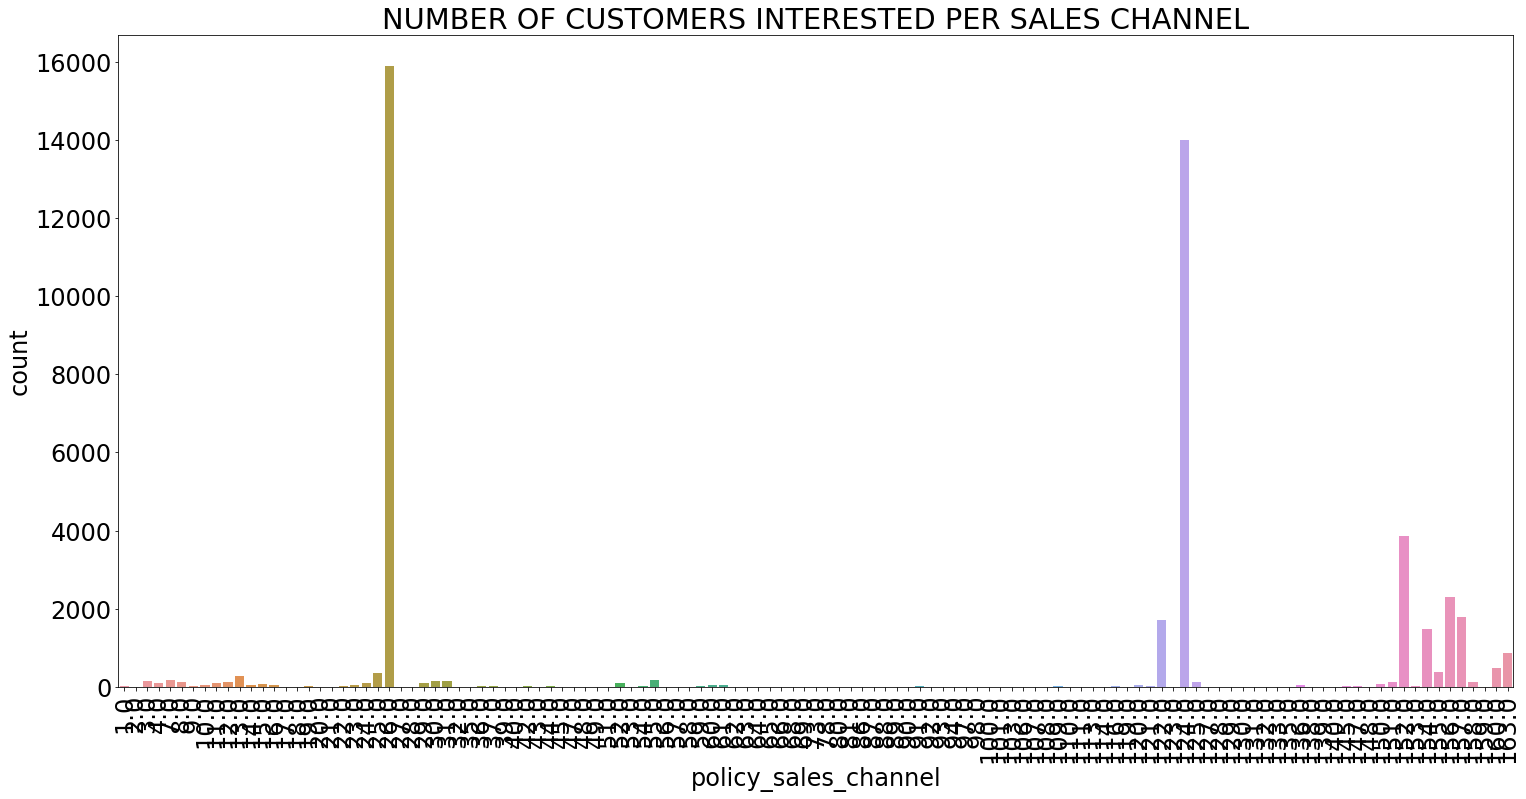

In [93]:
# plot response against policy_sales_channel
sns.countplot( x = 'policy_sales_channel', data = df4[ df4['response'] == 1 ])
plt.title( 'NUMBER OF CUSTOMERS INTERESTED PER SALES CHANNEL' )
plt.xticks( rotation = 90 );

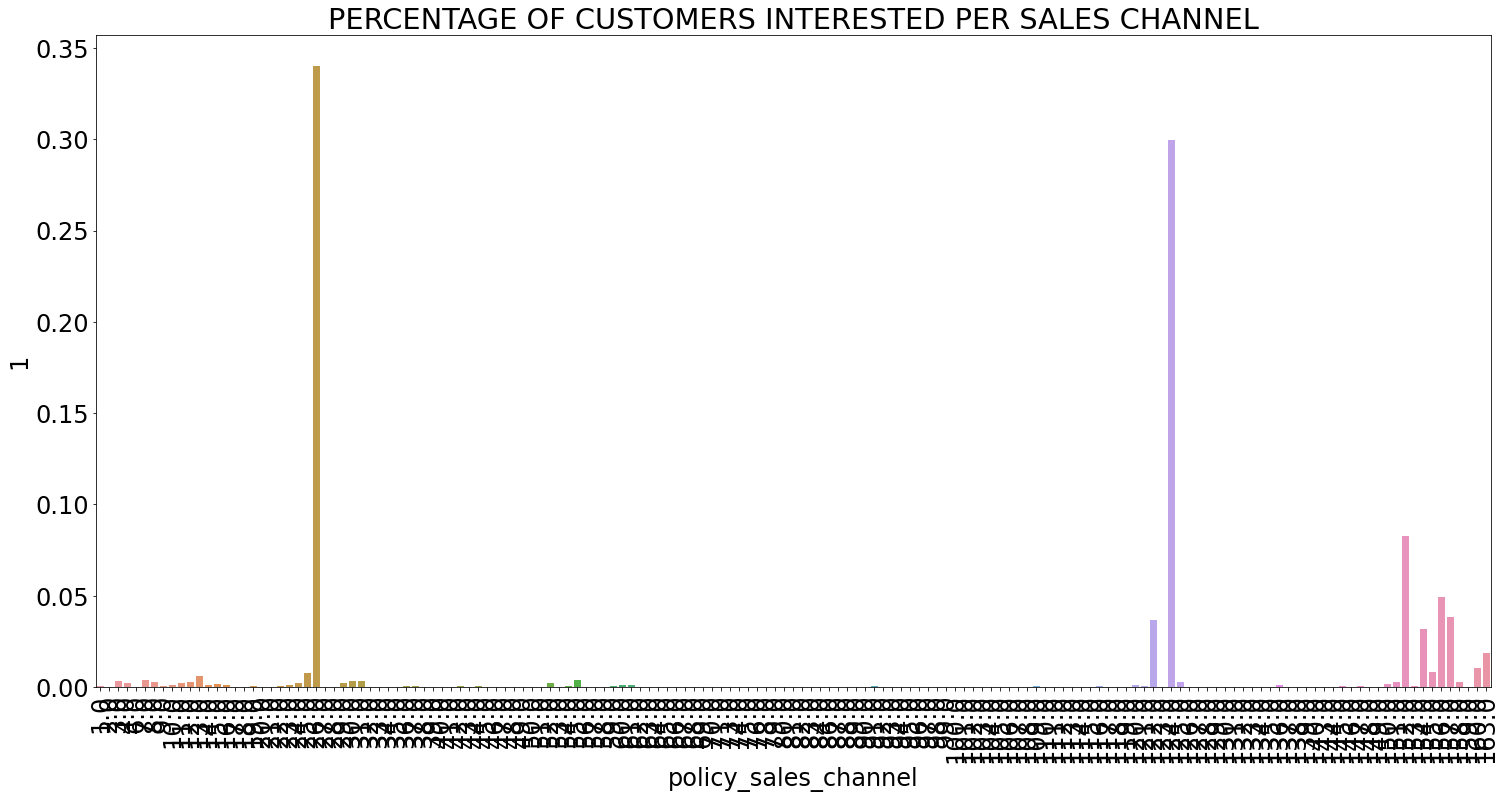

In [94]:
# plot response against policy_sales_channel
sns.barplot( x = 'policy_sales_channel', y = 1, data = df_h7.reset_index() )
plt.title( 'PERCENTAGE OF CUSTOMERS INTERESTED PER SALES CHANNEL' )
plt.xticks( rotation = 90 );

### H8. Considerando as pessoas interessadas em seguro de automóvel, a maioria já havia contratado seguro de automóvel no passado.

**H8 É FALSO**. A maioria dos clientes interessados nunca contratou seguro automóvel.

In [95]:
# create cross tabulation with previously_insured and response columns
df_h8 = pd.crosstab( df4['previously_insured'], df4['response'],
                     normalize = 'columns')

df_h8

response,0,1
previously_insured,,
0,0.478,0.997
1,0.522,0.003


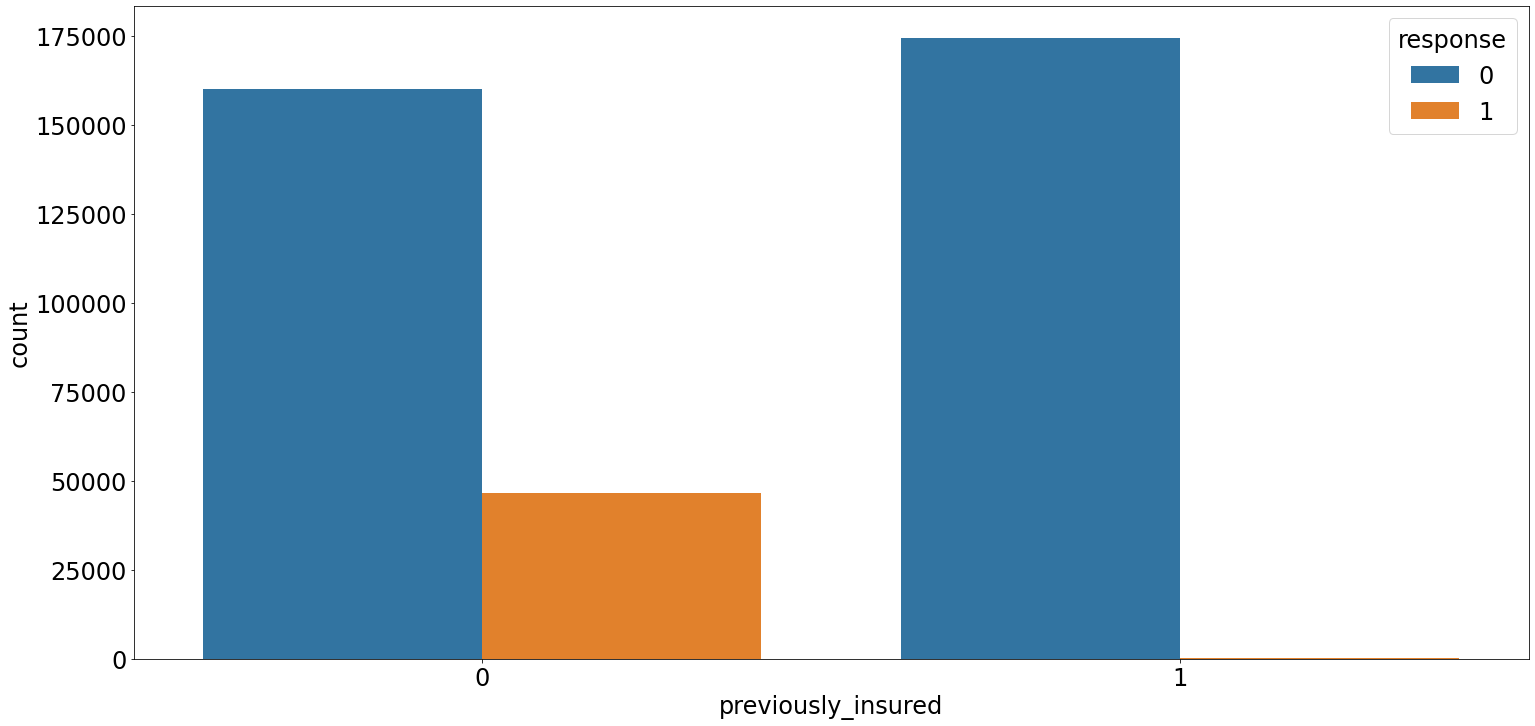

In [96]:
# plot response against previously_insured
sns.countplot( x = 'previously_insured', hue = 'response', data = df4);

### H9. Considerando as pessoas interessadas em seguro de automóvel, a maioria contratou seguro saúde mais barato no passado.

**H9 É FALSO**. O número de clientes interessados ​​nem sempre diminui com o aumento do prêmio anual de seguro saúde de contratos anteriores. Existe uma região de prémio anual de cerca de 35000 onde, quanto maior o prémio anual, maior é o número de clientes interessados.

In [97]:
# create cross tabulation with annual_premium and response columns
df_h9 = pd.crosstab( df4['annual_premium'], df4['response'] )
                     
df_h9.head()

response,0,1
annual_premium,,
2630.000,56372,8505
6098.000,1,0
7670.000,1,0
8739.000,1,0
9792.000,1,0


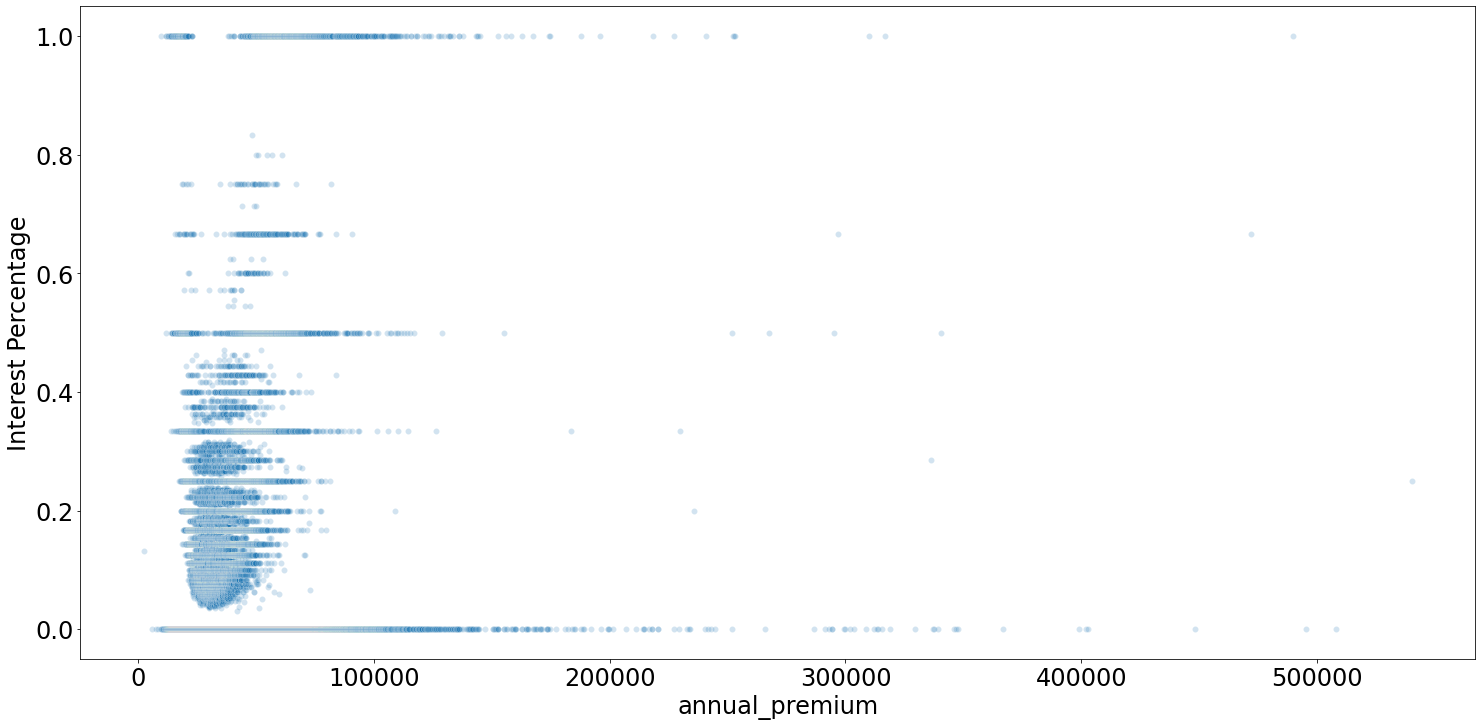

In [178]:
# plot interest percentage over annual_premium
sns.scatterplot( x = 'annual_premium', y = 1, data = df_h9_aux.reset_index(), alpha = 0.2 )
plt.ylabel( 'Interest Percentage' );

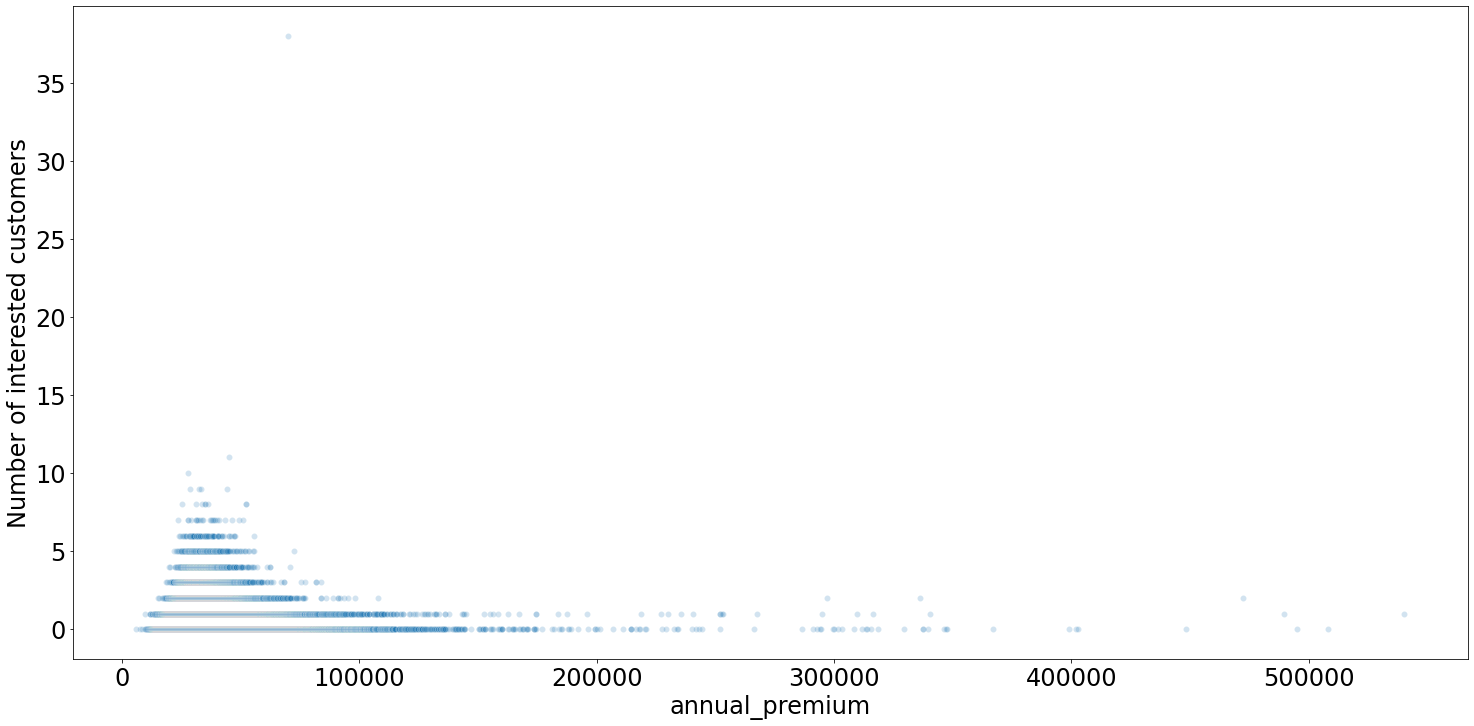

In [99]:
# create auxiliary dataframe
df_aux = df_h9.reset_index()

# plot number of interested customers against 'annual_premium > 3000'
sns.scatterplot( x = 'annual_premium', y = 1, data = df_aux[ df_aux['annual_premium'] > 3000], alpha = 0.2 )
plt.ylabel( 'Number of interested customers' );

In [100]:
# create auxiliary dataframe with percentage of interest per annual_premium
# normalize over rows
df_h9_aux = pd.crosstab( df4['annual_premium'], df4['response'],
                         normalize = 'index')

df_h9_aux.head()

response,0,1
annual_premium,,
2630.000,0.869,0.131
6098.000,1.000,0.000
7670.000,1.000,0.000
8739.000,1.000,0.000
9792.000,1.000,0.000


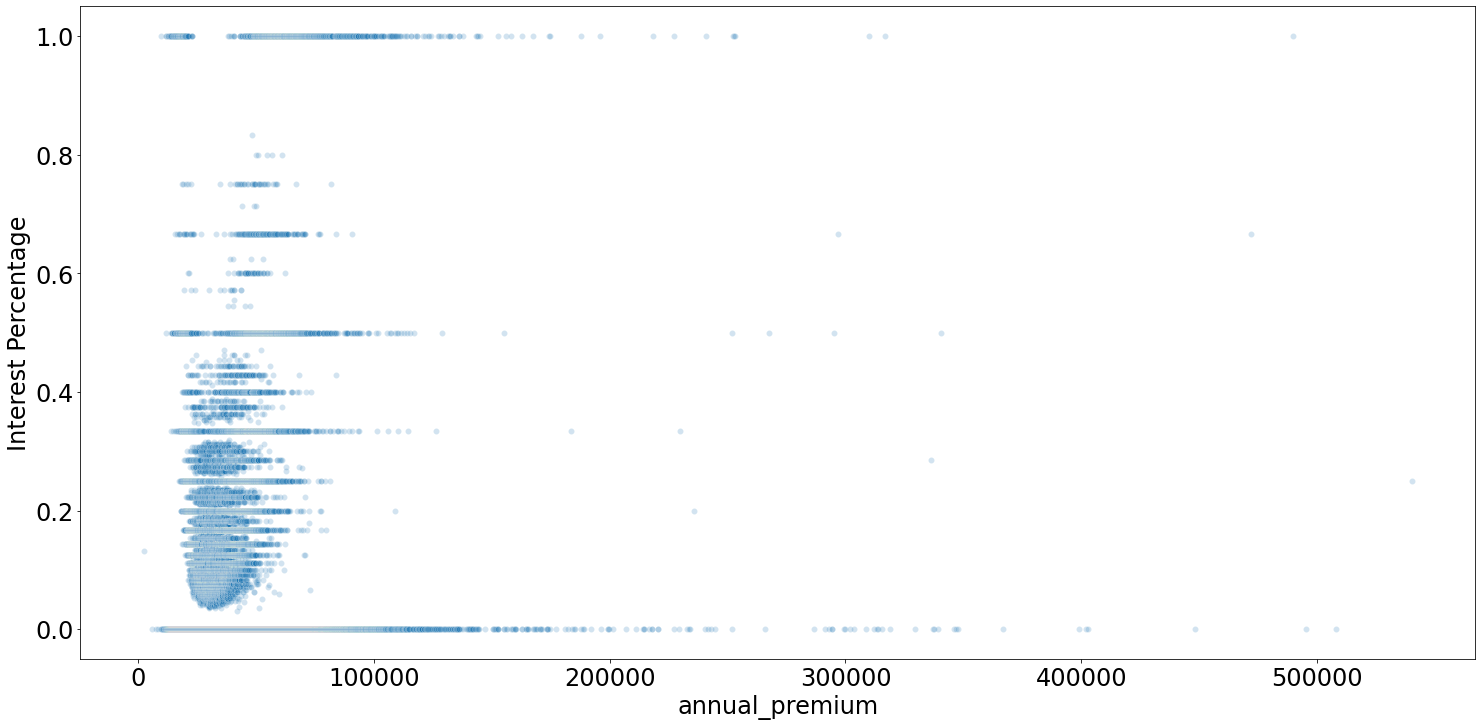

In [101]:
# plot interest percentage over annual_premium
sns.scatterplot( x = 'annual_premium', y = 1, data = df_h9_aux.reset_index(), alpha = 0.2 )
plt.ylabel( 'Interest Percentage' );

### H10. Considerando as pessoas interessadas em seguro de automóvel, a maioria delas havia contratado seguro saúde por um período maior de tempo.

**H10 É FALSO**. Não há uma relação clara entre o número de clientes interessados ​​e a duração dos contratos de seguro anteriores dos clientes.

In [102]:
# create cross tabulation with vintage and response columns
df_h10 = pd.crosstab( df4['vintage'], df4['response'],
                      normalize = 'columns')

df_h10

response,0,1
vintage,,
10,0.003,0.003
11,0.003,0.004
12,0.003,0.004
13,0.003,0.004
14,0.003,0.003
...,...,...
295,0.003,0.003
296,0.003,0.003
297,0.003,0.003


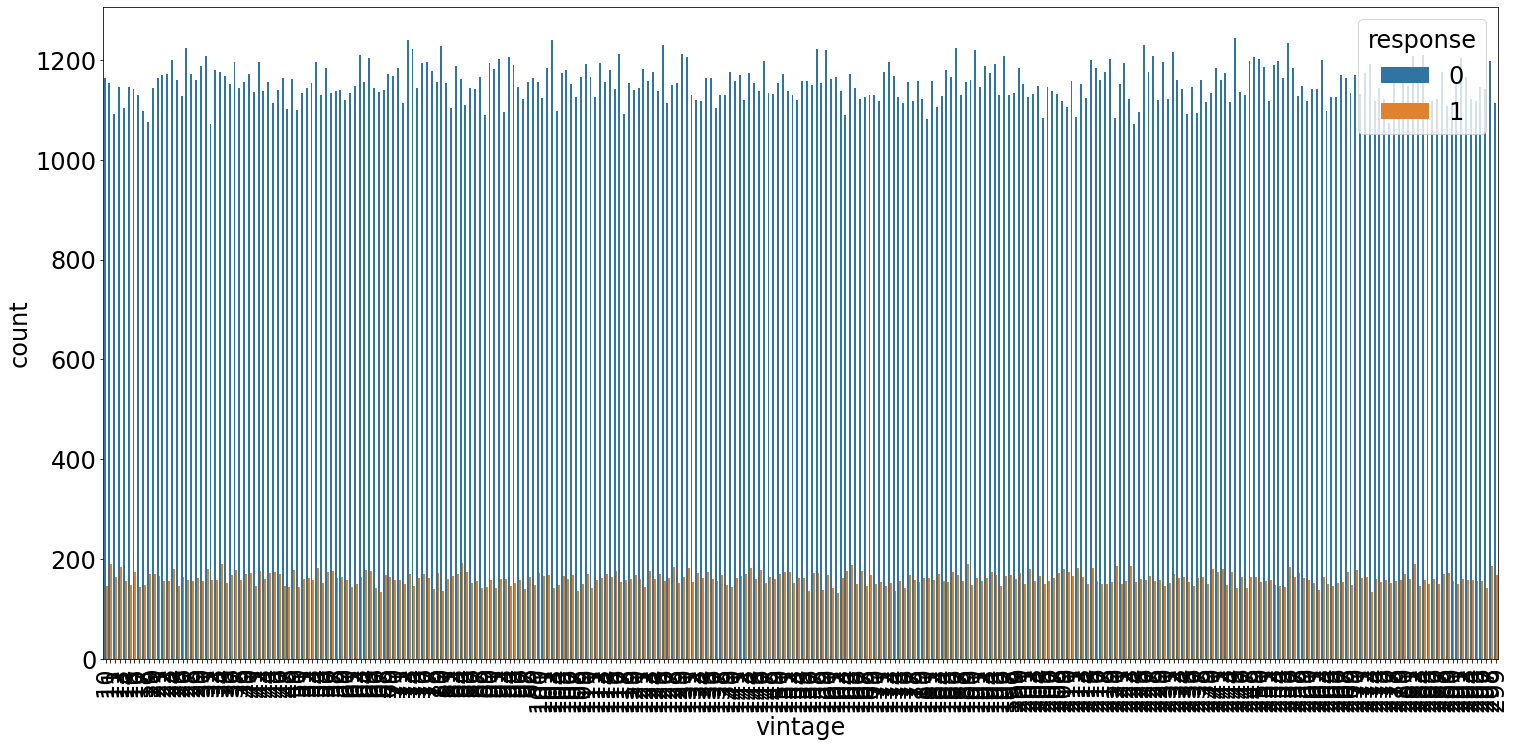

In [104]:
# plot response against vintage
sns.countplot(x = 'vintage', hue = 'response', data = df4)
plt.xticks( rotation = 90 );

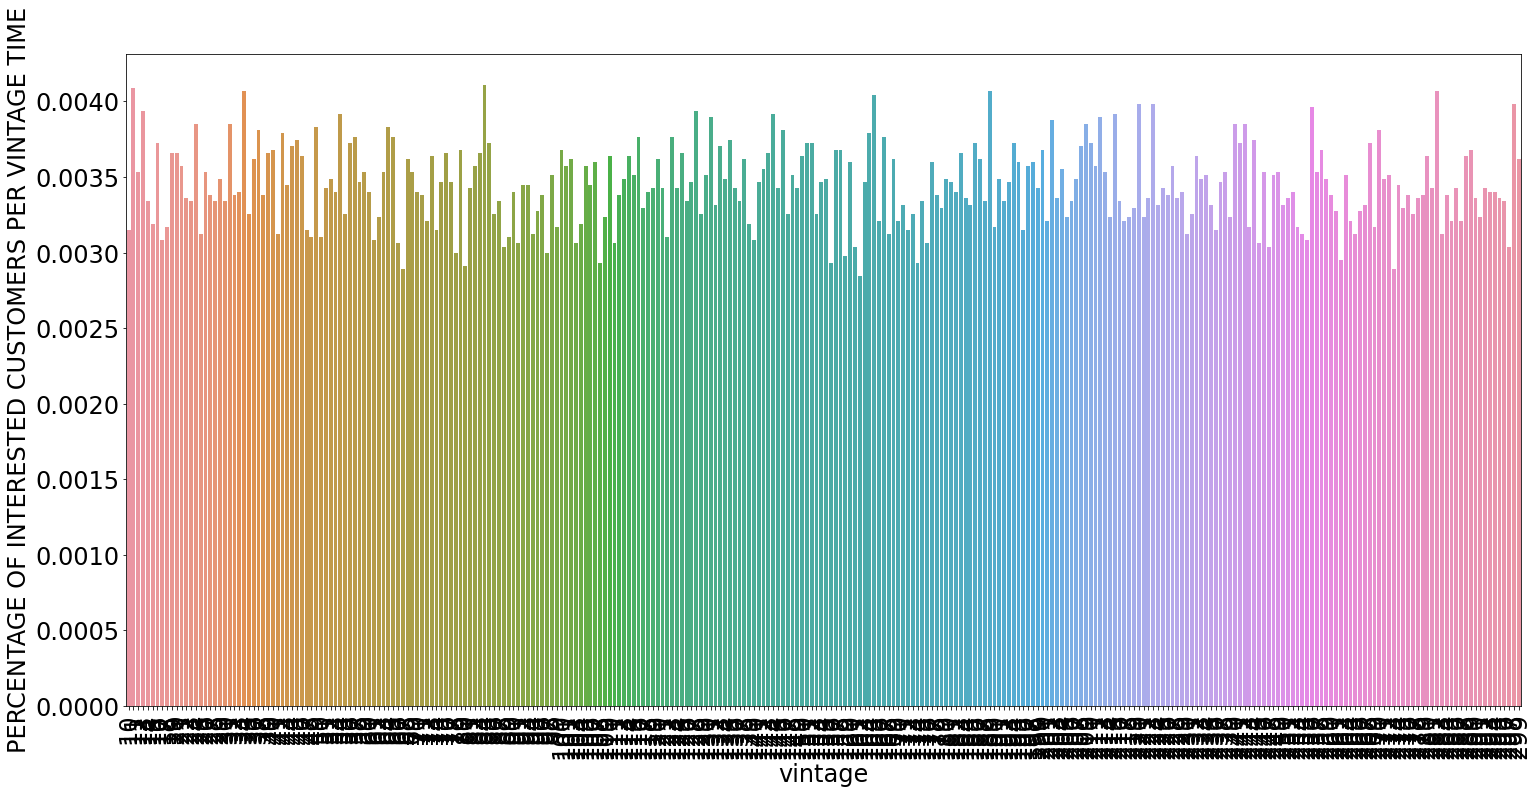

In [105]:
# plot percentage of interested customers per vintage time
sns.barplot( x = 'vintage', y = 1, data = df_h10.reset_index() )
plt.ylabel( 'PERCENTAGE OF INTERESTED CUSTOMERS PER VINTAGE TIME' )
plt.xticks( rotation = 90 );

### Sumary

In [109]:
hypothesis_tab = [
['H1', 'True'],
['H2', 'True'],
['H3', 'True'],
['H4', 'True'],
['H5', 'False'],
['H6', 'False'],
['H7', 'True'],
['H8', 'False'],
['H9', 'False'],
['H10', 'False'] 
]

pd.DataFrame( hypothesis_tab, columns = ['HYPOTHESIS', 'CONCLUSION'])

,HYPOTHESIS,CONCLUSION
0,H1,True
1,H2,True
2,H3,True
3,H4,True
4,H5,False
5,H6,False
6,H7,True
7,H8,False
8,H9,False
9,H10,False


In [110]:
features_tab = [
['gender', 'medium'],
['age', 'high'],
['region_code', 'medium'],
['policy_sales_channel', 'high' ],
['previously_insured', 'medium' ],
['annual_premium', 'high'],
['vintage', 'low'],
['driving_license', 'low' ],
['vehicle_age', 'medium'],
['vehicle_damage', 'medium'],
]

pd.DataFrame( features_tab, columns = ['FEATURES', 'RELEVANCE INTUITION'] )

,FEATURES,RELEVANCE INTUITION
0,gender,medium
1,age,high
2,region_code,medium
3,policy_sales_channel,high
4,previously_insured,medium
5,annual_premium,high
6,vintage,low
7,driving_license,low
8,vehicle_age,medium
9,vehicle_damage,medium


## 4.3 Multivariate analyses

In [111]:
# create dataframe with numerical features plus response column
bi_num_columns = list(num_features.columns)
multivar_num_analyses = df4[ bi_num_columns ]
multivar_num_analyses.head()

,age,annual_premium,vintage
0,44,40454.000,217
1,76,33536.000,183
2,47,38294.000,27
3,21,28619.000,203
4,29,27496.000,39


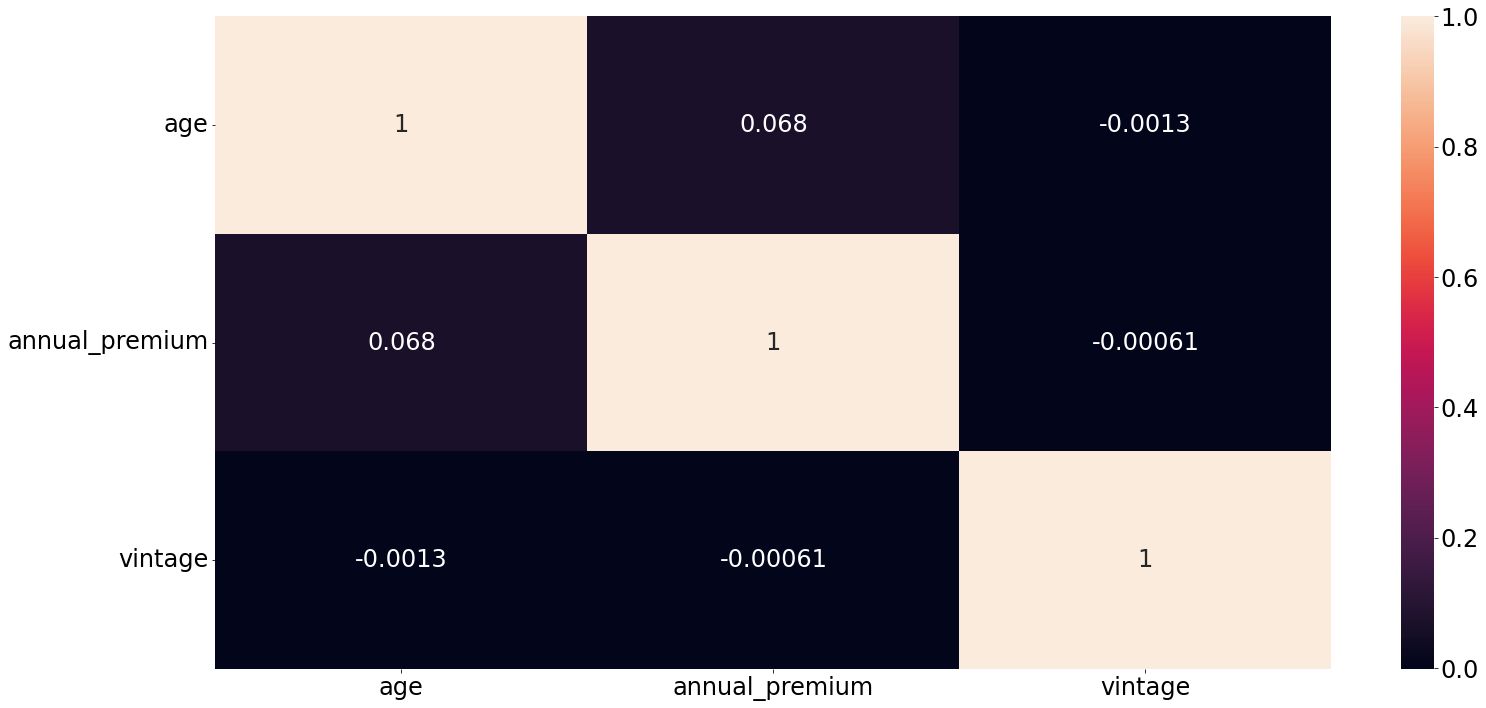

In [112]:
# calculate correlation for numerical features
correlation = multivar_num_analyses.corr( method = 'pearson' )

# display heatmap of correlation
sns.heatmap( correlation, annot = True)
plt.yticks( rotation = 0 );

### 4.3.1 Categorical Features

In [114]:
# create dataframe with categorical features plus response column
bi_cat_columns = list(cat_features.columns)
bi_cat_columns.append('response')
multivar_cat_analysis = df4[ bi_cat_columns ]

# check dataframe
multivar_cat_analysis.head()

,gender,region_code,policy_sales_channel,previously_insured,driving_license,vehicle_age,vehicle_damage,response
0,Male,28.000,26.000,0,1,over_2_years,1,1
1,Male,3.000,26.000,0,1,between_1_2_year,0,0
2,Male,28.000,26.000,0,1,over_2_years,1,1
3,Male,11.000,152.000,1,1,below_1_year,0,0
4,Female,41.000,152.000,1,1,below_1_year,0,0


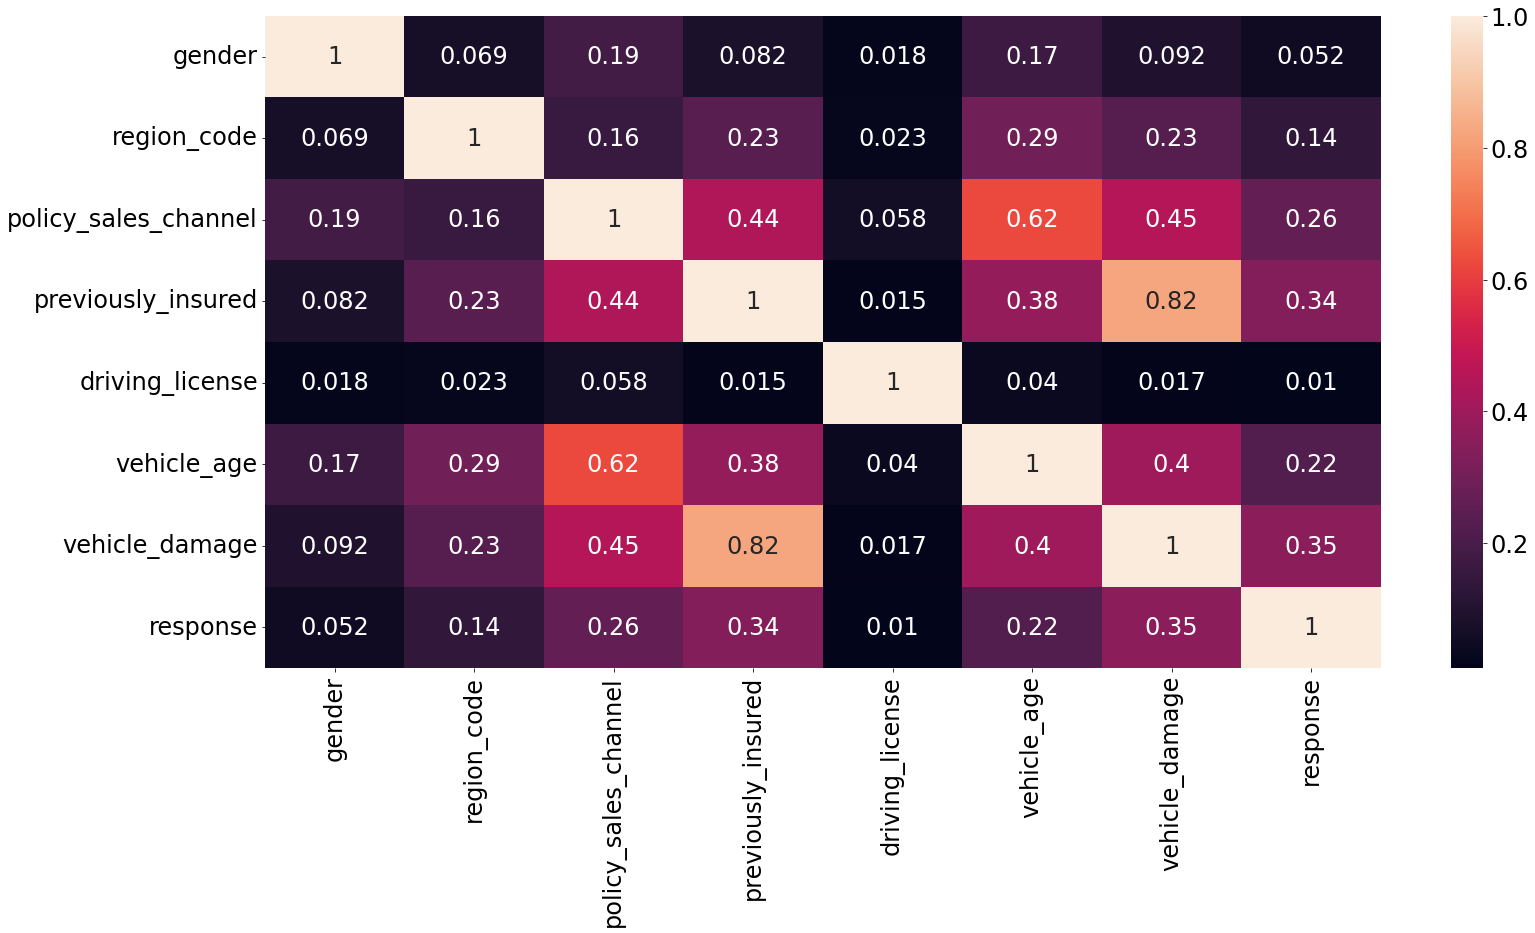

In [119]:
# create a dataframe with cramer-v for every row-column pair
cramer_v_corr = create_cramer_v_dataframe( multivar_cat_analysis )

# display heatmap
sns.heatmap( cramer_v_corr, annot = True);

# 5.0 Data Preparation

In [120]:
df5= df4.copy()

### Split dataframe into training and validation dataset

In [121]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [122]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
#pickle.dump( ss, open( '../pa004_health_insurance/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2 Rescaling

In [123]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump( mms_age, open( '../pa004_health_insurance/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump( mms_vintage, open( '../pa004_health_insurance/features/vintage_scaler.pkl', 'wb' ) )



## 5.3 Encoder

In [124]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump( target_encode_gender, open( '../pa004_health_insurance/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump(target_encode_region_code, open( '../pa004_health_insurance/features/target_encode_region_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
target_encode_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( target_encode_policy_sales_channel )
#pickle.dump(target_encode_policy_sales_channel, open( '../pa004_health_insurance/features/target_encode_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.2 Validation Preparation

In [125]:
 # gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( target_encode_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 Feature Selection

Esta etapa server para determinar qual é a melhor combinação de variáveis a ser utilizada.



## 6.1 Feature importance

### 6.1.1 Extra Trees Classifier

O Extremely Randomized Trees Classifier (Extra Trees Classifier) é um tipo de técnica de aprendizagem de conjunto que agrega os resultados de várias árvores de decisão descorrelacionadas coletadas em uma “floresta” para produzir seu resultado de classificação. Em conceito, é muito semelhante a um Classificador Random Forest e só difere na forma de construção das árvores de decisão na floresta.

Cada árvore de decisão na floresta de árvores extras é construída a partir da amostra de treinamento original. Então, em cada nó de teste, cada árvore é fornecida com uma amostra aleatória de k recursos do conjunto de recursos a partir do qual cada árvore de decisão deve selecionar o melhor recurso para dividir os dados com base em alguns critérios matemáticos (normalmente o índice de Gini). Essa amostra aleatória de recursos leva à criação de várias árvores de decisão não correlacionadas.

Para realizar a seleção de características usando a estrutura de floresta acima, durante a construção da floresta, para cada característica, a redução total normalizada nos critérios matemáticos usados ​​na decisão da característica de divisão (Índice de Gini se o Índice de Gini for usado na construção de floresta) é computado. Esse valor é chamado de Importância Gini do recurso. Para realizar a seleção de recursos, cada recurso é ordenado em ordem decrescente de acordo com a Importância Gini de cada recurso e o usuário seleciona os k principais recursos de acordo com sua escolha.

In [126]:
# model definition
#et_model = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )
#
# data preparation
#x_train_n = df5.drop( ['id', 'response'], axis=1 )
#y_train_n = y_train.values
#et_model.fit( x_train_n, y_train_n )

In [127]:
#importances = et_model.feature_importances_
#indices = np.argsort( importances )[::-1]
#
#print( 'feature ranking')
#df = pd.DataFrame()
#
#for i, j in zip( x_train_n, et_model.feature_importances_ ):
#    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
#    df = pd.concat( [df, aux], axis=0 )
#    
#print( df.sort_values( 'importance', ascending=False ) )
#
## Plot the impurity-based feature importances of the forest
#plt.figure()
#plt.title("Feature importances")
#plt.bar(range(x_train_n.shape[1]), importances[indices], color="c", align="center")
#plt.xticks(range(x_train_n.shape[1]), indices)
#plt.xlim([-1, x_train_n.shape[1]])
#plt.show()

# 7.0 Machine Learning Modelling

In [128]:
cols_selected = [ 'annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [129]:
x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1 Logistic regression

In [130]:
#model definition
lr_model = lm.LogisticRegression( random_state=42 ) 
 #model training
lr_model.fit( x_train, y_train )
 #model prediction
yhat_lr = lr_model.predict_proba( x_val )

In [131]:
# save the lr_model trained model
#with open( 'model/lr_model.pkl', 'wb') as file:
#    pickle.dump( lr_model, file )

In [132]:
# Load the Model back from file
with open('model/lr_model.pkl', 'rb') as file:  
    lr_model = pickle.load( file )

In [133]:
# model prediction - probability
yhat_lr = lr_model.predict_proba( x_val )

In [134]:
# model size
lr_model_size_mb = round( os.path.getsize('model/lr_model.pkl') / (1024**2), 2)

## 7.2 KNN

In [135]:
 # model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )
 #model training
knn_model.fit( x_train, y_train )
# model predicion - Poder de Generalização do modelo
yhat_knn = knn_model.predict_proba( x_val )

In [136]:
# save the knn_model trained model
#with open( 'model/knn_model.pkl', 'wb') as file:
#    pickle.dump( knn_model, file )

In [137]:
# Load the Model back from file
with open('model/knn_model.pkl', 'rb') as file:  
    knn = pickle.load( file )

In [138]:
# model prediction - probability
yhat_knn = knn_model.predict_proba( x_val )

In [139]:
# model size
knn_size_mb = round( os.path.getsize('model/knn_model.pkl') / (1024**2), 2)
knn_size_mb

22.02

## 7.3 Random Forest

In [140]:
# model definition
rf = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
#Model fit
rf.fit(x_train, y_train)
#Model predict
yhat_rf = rf.predict_proba(x_val)

In [141]:
# save the rf_model trained model
#with open( 'model/rf.pkl', 'wb') as file:
#    pickle.dump( rf, file )

In [142]:
# Load the Model back from file
with open('model/rf.pkl', 'rb') as file:  
    knn = pickle.load( file )

## 7.4 XGBoost

In [143]:
 # model definition
xgb = XGBClassifier( use_label_encoder = False, n_jobs = -1, seed = 10 )
 # model training
xgb.fit(x_train, y_train);
# model prediction - probability
yhat_xgb = xgb.predict_proba( x_val )

In [144]:
 #save the xgb_model trained model
#with open( 'model/xgb.pkl', 'wb') as file:
#    pickle.dump( xgb, file )

In [145]:
# Load the Model back from file
with open('model/xgb.pkl', 'rb') as file:  
    knn = pickle.load( file )

## 7.5 LightGBM

In [146]:
# model definition
lgbm = LGBMClassifier( n_jobs = -1, random_state = 10 )
#model training
lgbm.fit(x_train, y_train)
 #model prediction - probability
yhat_lgbm = lgbm.predict_proba( x_val )

In [147]:
# save the xgb_model trained model
#with open( 'model/lgbm.pkl', 'wb') as file:
   # pickle.dump( lgbm, file )

In [148]:
# Load the Model back from file
with open('model/lgbm.pkl', 'rb') as file:  
    knn = pickle.load( file )

# 8.0 Model Performance

<AxesSubplot:title={'center':'XGBOOST'}, xlabel='Percentage of sample', ylabel='Gain'>

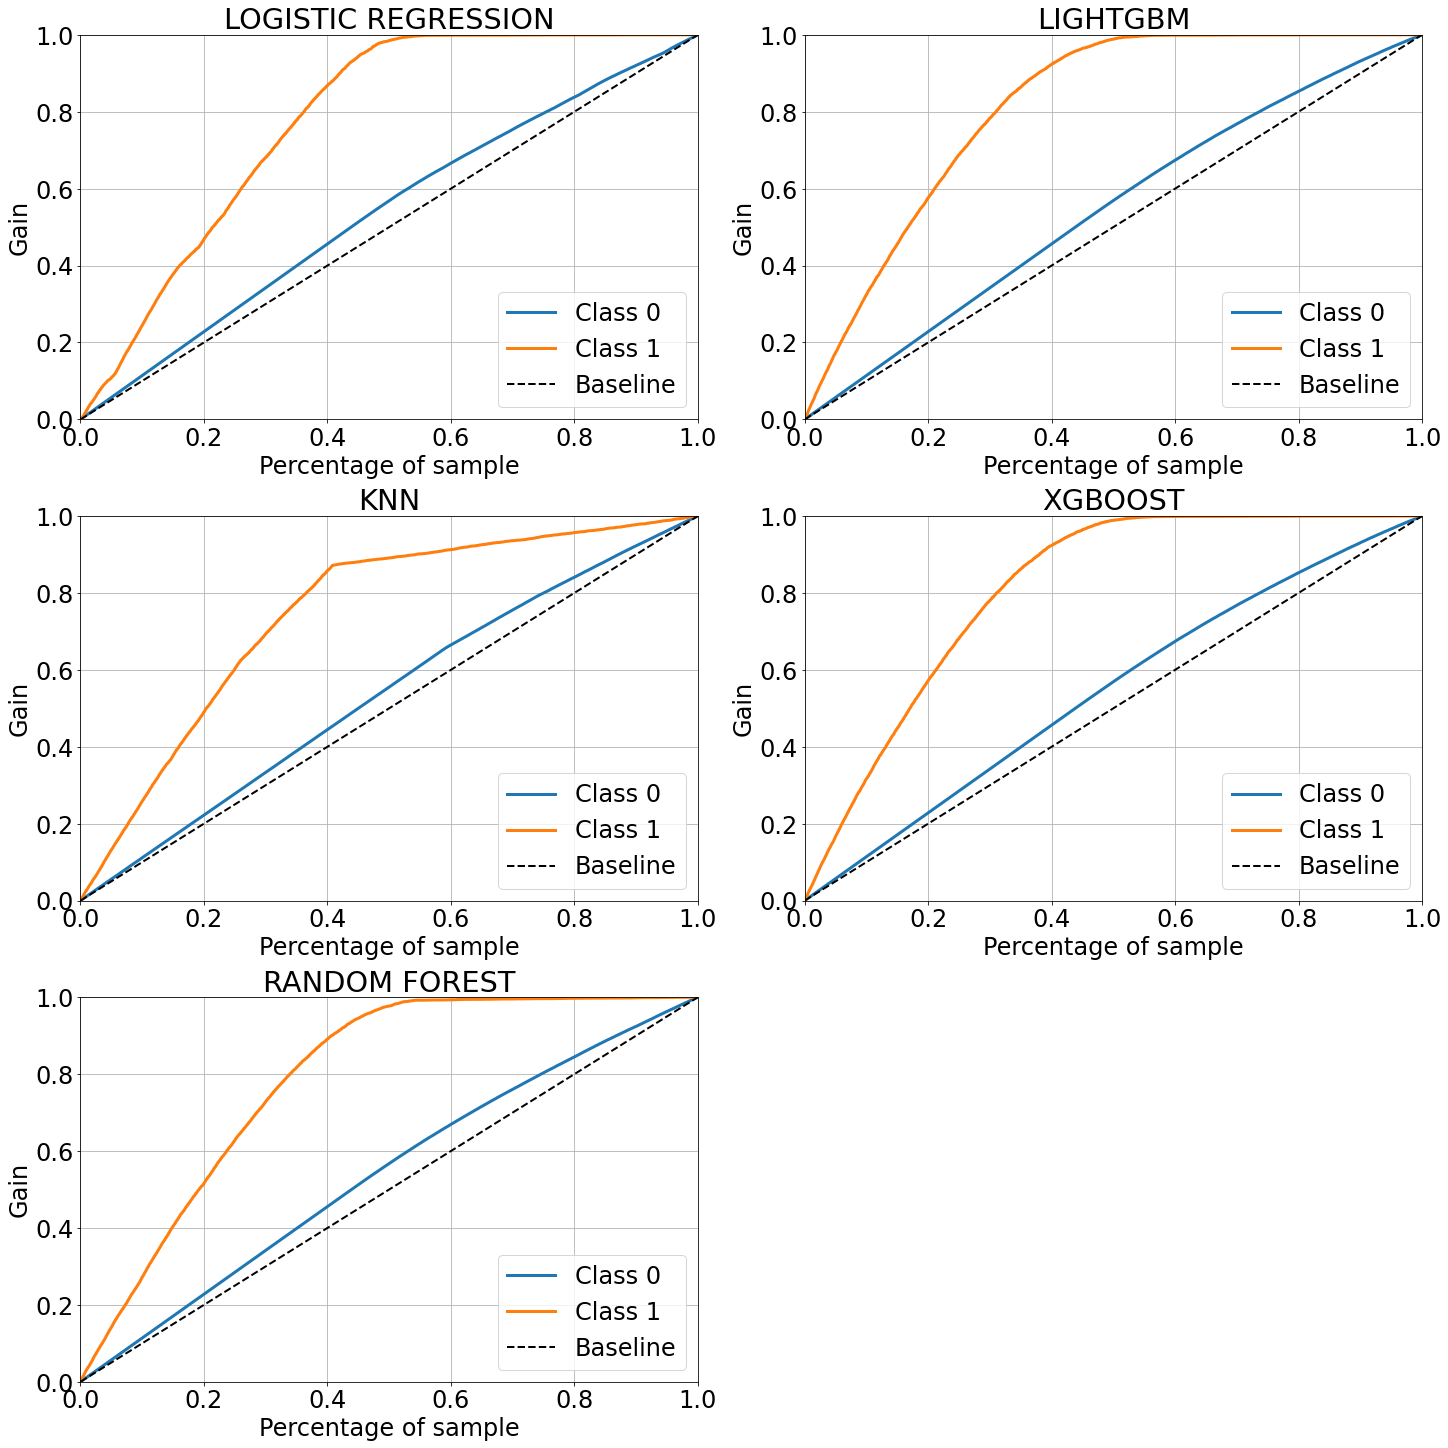

In [169]:
# create a figure object
fig = plt.figure( figsize = (20, 20) , constrained_layout = True )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 2, nrows = 3, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )
ax4 = fig.add_subplot( specs[ 0, 1 ] )
ax5 = fig.add_subplot( specs[ 1, 1 ] )


# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                   yhat_lr, 
                                    title = 'LOGISTIC REGRESSION', ax = ax1    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_knn,
                                    title = 'KNN',                 ax = ax2    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_rf,
                                    title = 'RANDOM FOREST',       ax = ax3    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_lgbm, 
                                    title = 'LIGHTGBM',            ax = ax4    )


# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_xgb,
                                    title = 'XGBOOST',             ax = ax5    )



In [150]:
# list predictions made
yhat_predictions = { 'Logistic Regression': [yhat_lr] , 
                     'KNN': [yhat_knn], 
                     'Random Forest': [yhat_rf],
                     'XGBoost': [yhat_xgb],
                     'LightGBM': [yhat_lgbm],
                     }

# create dataframe to compare models
performance_comparison = pd.DataFrame()

for model_name, model in yhat_predictions.items():
    # create model key
    row = {'Model': model_name}
    
    # create model 
   # row['Size in MB'] = model[1]
        
    # order validation according to propensity score
    df_propensity_ordered = propensity_score_ordering( x_val, y_validation, model[0])

    # compute precision at k
    row['recall_at_20000'] = recall_at_k(  df_propensity_ordered, k = 20000 )
    row['recall_at_40000'] = recall_at_k(  df_propensity_ordered, k = 40000 )
        
    # compute precision at k
    row['precision_at_20000'] = precision_at_k( df_propensity_ordered, k = 20000 )
    row['precision_at_40000'] = precision_at_k( df_propensity_ordered, k = 40000 )
            
    # append to comparison dataframe    
    performance_comparison = performance_comparison.append(row, ignore_index = True)

performance_comparison.sort_values( ['recall_at_20000', 'recall_at_40000'], 
                                    ascending = False )    

C:\Users\PC\AppData\Local\Temp\ipykernel_11992\3377444086.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PC\AppData\Local\Temp\ipykernel_11992\3377444086.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PC\AppData\Local\Temp\ipykernel_11992\3377444086.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PC\AppData\Local\Temp\ipykernel_11992\3377444086.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PC\AppData\Local\Temp\ipykernel_11992\3377444086.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,recall_at_20000,recall_at_40000,precision_at_20000,precision_at_40000
4,LightGBM,0.711,0.994,0.335,0.235
3,XGBoost,0.707,0.994,0.334,0.234
2,Random Forest,0.654,0.987,0.308,0.233
1,KNN,0.630,0.898,0.297,0.212
0,Logistic Regression,0.605,0.993,0.285,0.234


## 8.1 Model Selection

Due to the above explanation, the chosen model is LightGBM.

# 9.0 HYPERPARAMETER FINE TUNING

In [151]:
# params_search = { 
#     'n_estimators': [30, 100, 300],
#     'learning_rate': [0.03, 0.1, 0.3],
#     'num_leaves': [10, 30, 100],
#     }

# # create best params dataframe
# df_params_performance = pd.DataFrame()

# # number of iterations
# total_iterations = np.prod( [len(value) for value in params_search.values()] )

# # initialize iterations
# iteration = 1

# # perform RANDOM SEARCH to find best params
# for n_est in params_search['n_estimators']:
#     for l_rate in params_search['learning_rate']:
#         for n_lvs in params_search['num_leaves']:
#             # display iteration number
#             print( f'At {iteration} / {total_iterations} iteration.')
            
#             # define choosen params
#             chosen_params = { 'n_estimators':  n_est,
#                               'learning_rate': l_rate,
#                               'num_leaves':    n_lvs
#                             }                            
                
#             # define model with random params
#             lgbm = LGBMClassifier( n_estimators  = n_est,
#                                    learning_rate = l_rate,
#                                    num_leaves    = n_lvs,
#                                    n_jobs        = -1,
#                                    random_state  = 10
#                                  )  

#             # train model
#             lgbm.fit( X_train_model, y_train_model )

#             # model prediction
#             yhat_lgbm = lgbm.predict_proba( X_validation_model )

#             # order validation according to propensity score
#             df_propensity_ordered = propensity_score_ordering( X_validation, y_validation, yhat_lgbm )

#             # compute precision at k
#             precision_at_20000 = precision_at_k( df_propensity_ordered, k = 20000 )
#             precision_at_40000 = precision_at_k( df_propensity_ordered, k = 40000 )

#             # compute precision at k
#             recall_at_20000 = recall_at_k( df_propensity_ordered, k = 20000 )
#             recall_at_40000 = recall_at_k( df_propensity_ordered, k = 40000 )

#             # create row for dataframe appending
#             row = chosen_params
#             row['recall_at_20000']    = recall_at_20000
#             row['recall_at_40000']    = recall_at_40000
#             row['precision_at_40000'] = precision_at_40000,
#             row['precision_at_20000'] = precision_at_20000,

#             # append row to dataframe
#             df_params_performance = df_params_performance.append(row, ignore_index = True)

#             # increase iteration number
#             iteration += 1

            
# df_params_performance.sort_values( ['recall_at_20000', 'recall_at_40000', 
#                                     'precision_at_20000', 'precision_at_40000'], ascending = False )


In [152]:
# best params according to random search
best_params = { 'n_estimators': 30,
                'learning_rate': 0.1,
                'num_leaves': 10,
              }

## 9.1 PERFORMANCE EVALUATION AND INTERPRETATION

### 9.1.1 Generalization Performance

In [153]:
# define final model with optimal hyperparameters
lgbm_tuned = LGBMClassifier( n_estimators = 30, learning_rate = 0.1,
                             num_leaves = 10,  n_jobs = -1, random_state = 10 )                     

# model training
lgbm_tuned.fit( x_train, y_train )

LGBMClassifier(n_estimators=30, num_leaves=10, random_state=10)

In [154]:
# model prediction - probability
yhat_lgbm_tuned = lgbm_tuned.predict_proba( x_val)

Recall    at 20.000: 0.7090620031796503
Recall    at 40.000: 0.9940646528881824
Precision at 20.000: 0.3344832758362082
Precision at 40.000: 0.2344691382715432


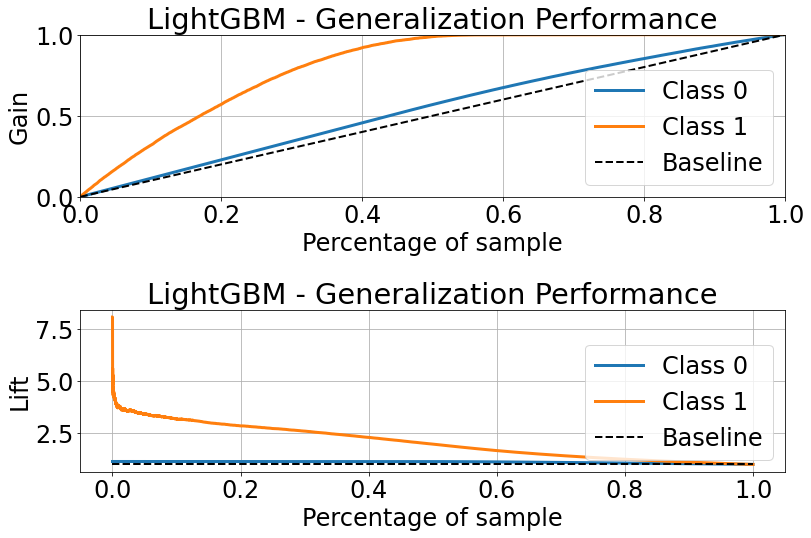

In [170]:
# order validation according to propensity score
df_propensity_ordered = propensity_score_ordering( x_val, y_validation, yhat_lgbm_tuned)

# compute recall at k
recall_at_20000 = recall_at_k( df_propensity_ordered, k = 20000 )
print( f'Recall    at 20.000: {recall_at_20000}' )    
recall_at_40000 = recall_at_k( df_propensity_ordered, k = 40000 )
print( f'Recall    at 40.000: {recall_at_40000}' )    

# compute precision at k
precision_at_20000 = precision_at_k( df_propensity_ordered, k = 20000 )
print( f'Precision at 20.000: {precision_at_20000}' )
precision_at_40000 = precision_at_k( df_propensity_ordered, k = 40000 )
print( f'Precision at 40.000: {precision_at_40000}' )

# prepare figure
fig = plt.figure( figsize = (12,8), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 211 )
ax2 = fig.add_subplot( 212 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm_tuned, 
                                    title = 'LightGBM - Generalization Performance', ax = ax1 )

# plot lift curve
skplt.metrics.plot_lift_curve( y_validation, yhat_lgbm_tuned, 
                               title = 'LightGBM - Generalization Performance', ax = ax2 );

In [156]:
x_val.shape

(76222, 7)

In [157]:
x_train.shape

(304887, 7)

In [158]:
 # Save the lgbm trained model
#with open( 'model/model_health_insurance.pkl', 'wb' ) as file:
        #pickle.dump( lgbm_tuned, file )

In [159]:
# Load the Model back from file
with open( 'model/model_health_insurance.pkl', 'rb') as file:  
    model_health_insurance = pickle.load( file )

### Making 20.000 phone calls, what percentage of interested clients the sales team will get in contact with?

In [160]:
# calculate proportion of interested in test data
interested_percentage = y_validation.sum() / y_validation.shape[0]

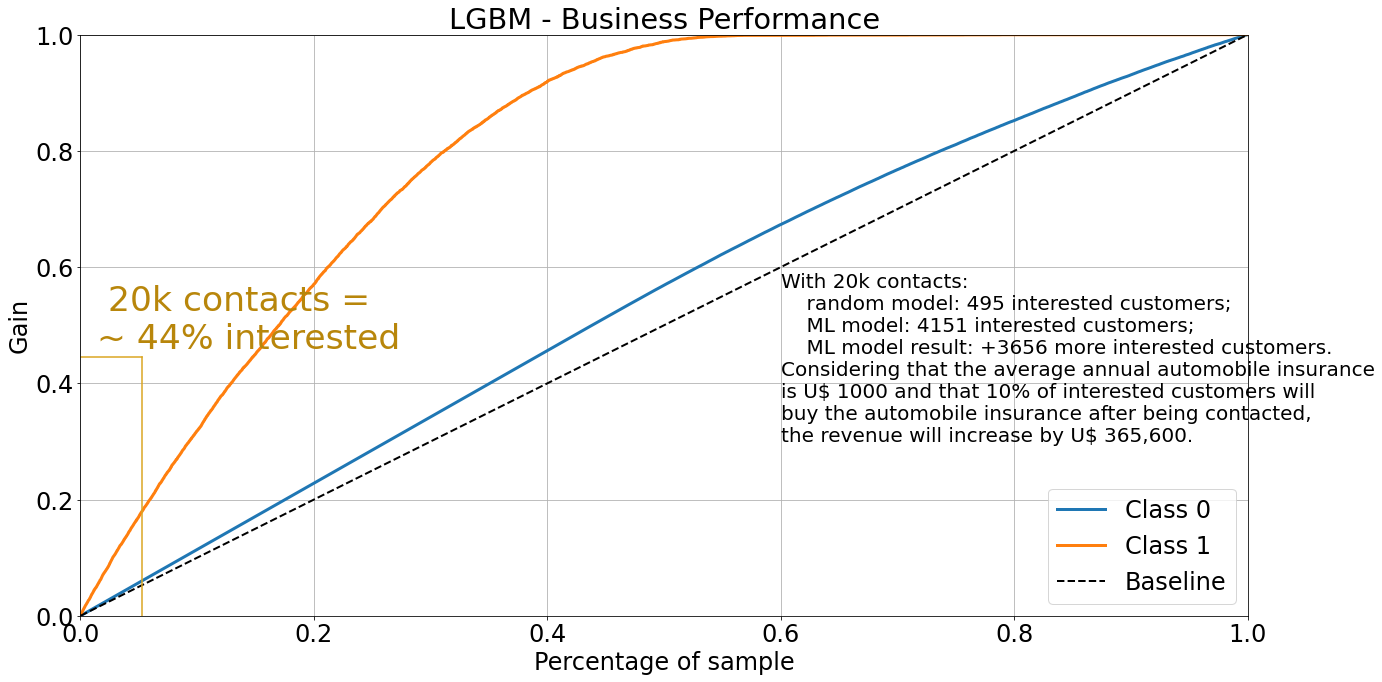

In [175]:
# calculate how much 20k represents to total sample of production data
twenty_k_percentage = ( 20000 / df_raw.shape[0] ) 

# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm_tuned, 
                                    title = 'LGBM - Business Performance', ax = ax1 );

# add 20000 customers contacted line
ax1.axvline( twenty_k_percentage, ymax = 0.445, color = 'goldenrod', label = '20k' )
ax1.axhline( 0.445 , xmax = twenty_k_percentage, color = 'goldenrod' )
plt.text( 0.005 , 0.45 + 0.01, '  20k contacts =\n ~ 44% interested' , 
          color = 'darkgoldenrod', fontsize = 'x-large' );

# calculate number of interested customers with ML model
ml_customers_twenty = int( y_validation.shape[0] * interested_percentage * 0.44 )
# calculate number of interested customers with random model
random_customers_twenty = int( y_validation.shape[0] * interested_percentage * twenty_k_percentage )
# calculate how many customers ML will increase
ml_customers_increase = int( ml_customers_twenty - random_customers_twenty )


# display business message
message = f'\
With 20k contacts: \
\n    random model: {random_customers_twenty} interested customers;\
\n    ML model: {ml_customers_twenty} interested customers;\
\n    ML model result: +{ml_customers_twenty - random_customers_twenty} more interested customers.\
\nConsidering that the average annual automobile insurance\n\
is U\$ 1000 and that 10% of interested customers will\n\
buy the automobile insurance after being contacted,\n\
the revenue will increase by U$ {int( 0.1 * ( (ml_customers_increase * 1000) ) ):,}.'
plt.text( 0.6 , 0.3, message, color = 'black', fontsize = 'small' );

# save image
# with open( '../images/second_business_question.png', 'wb' ) as img:
#     plt.savefig( img )


### If the sales team expand its capacity to make 40.000 phone calls, what is the percentage of interested clients the sales team will get in contact with?

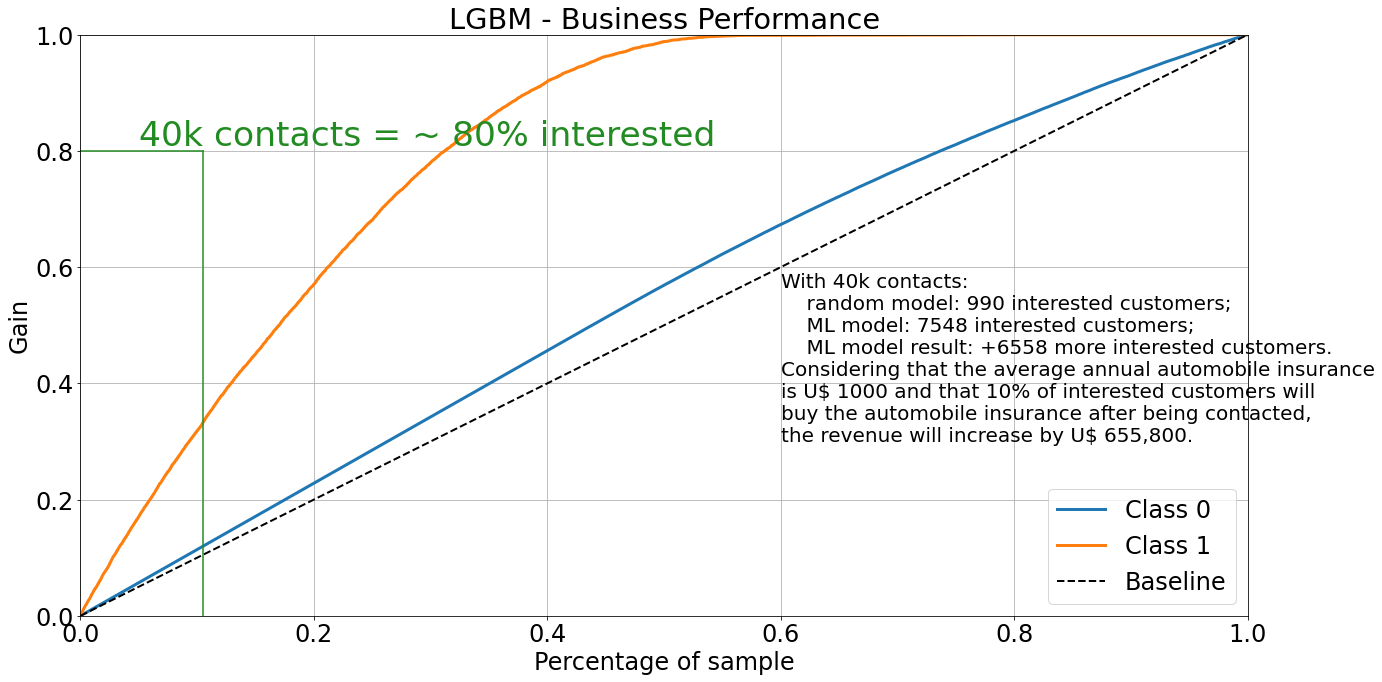

In [176]:
# calculate how much 40k represents to total sample
fourty_k_percentage = ( 40000 / df_raw.shape[0] ) 

# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm_tuned, 
                                    title = 'LGBM - Business Performance', ax = ax1 );

# add 40000 customers contacted line
ax1.axvline( fourty_k_percentage, ymax = 0.8, color = 'forestgreen', label = '40k' )
ax1.axhline( 0.8, xmax = fourty_k_percentage, color = 'forestgreen' )
plt.text( 0.05 , 0.8 + 0.01 , '40k contacts = ~ 80% interested' , 
          color = 'forestgreen', fontsize = 'x-large' );

# calculate number of interested customers with ML model
ml_customers_fourty = int( y_validation.shape[0] * interested_percentage * 0.8 )
# calculate number of interested customers with random model
random_customers_fourty = int( y_validation.shape[0] * interested_percentage * fourty_k_percentage )
# calculate how many customers ML will increase
ml_customers_increase = int( ml_customers_fourty - random_customers_fourty )

# display business message
message = f'\
With 40k contacts: \
\n    random model: {random_customers_fourty} interested customers;\
\n    ML model: {ml_customers_fourty} interested customers;\
\n    ML model result: +{ml_customers_fourty - random_customers_fourty} more interested customers.\
\nConsidering that the average annual automobile insurance\n\
is U\$ 1000 and that 10% of interested customers will\n\
buy the automobile insurance after being contacted,\n\
the revenue will increase by U$ {int( 0.1 * ( (ml_customers_increase * 1000) ) ):,}.'
plt.text( 0.6 , 0.3, message, color = 'black', fontsize = 'small' );


# save image
# with open( '../images/third_business_question.png', 'wb' ) as img:
#     plt.savefig( img )